# Top-Hat Jet — Log-Normal θ_c (Multi-Population Runs)

> **Source**: copied from `../Top_Hat_Models_LN.ipynb`  
> **Cleaned version**: see `tutorial2_tophat.ipynb` for a single-population tutorial.

This notebook focuses on the **Log-Normal $\theta_c$** top-hat model with:
- $\theta_{c,\mathrm{med}}$ in linear scale and $f_j < 1$
- Custom geometric efficiency interpolator (inline)
- **Multi-population loop** running across all population synthesis samples
- Extensive multi-population comparison plots

The tutorial version covers a single population; this notebook extends to all populations.

In [2]:
%load_ext autoreload
%autoreload 2

import  src.init
import  emcee
import  corner
import  numpy                   as np 
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path
from    src.top_hat.montecarlo  import *
from    src.top_hat.plot           import TopHatPlotter

plt.style.use('./configurations/style.mplstyle') #? Custom style, makes plots easier to read

In [3]:
datafiles   = Path("datafiles")
N_WALKERS   = 20

# Log-Normal

In [4]:
from src.top_hat.montecarlo import *

N_PARAMS        = 6
PARAM_NAMES     = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_med", "fj"]

def log_prior_log_normal(thetas):
    # Change the variable name from theta_c_med_10 to theta_c_med
    A_index, L_L0, L_mu_E, sigma_E, theta_c_med, fj = thetas

    if not (1.5 < A_index       < 12): return -inf
    if not (-2  < L_L0          < 7): return -inf
    if not (0.1 < L_mu_E        < 7): return -inf
    if not (0   < sigma_E       < 2.5): return -inf
    if not (1   < theta_c_med   < 25): return -inf
    if not (0   < fj            < 1): return -inf
    
    return 0.0


from scipy.interpolate import interp1d
def create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5, n_points=200):
    """
    Create an interpolator for lognormal geometric efficiency.
    
    Call this once before MCMC, then use the returned function.
    """
    theta_c_med_grid = np.linspace(1, 25, n_points)
    
    efficiencies = np.array([
        _calculate_geometric_efficiency_lognormal_raw(t, sigma_theta_c) 
        for t in theta_c_med_grid
    ])
    
    return interp1d(theta_c_med_grid, efficiencies, kind='cubic', 
                    bounds_error=False, fill_value=(efficiencies[0], efficiencies[-1]))

def _calculate_geometric_efficiency_lognormal_raw(theta_c_med, sigma_theta_c=0.5):
    """Raw calculation - use interpolator version in MCMC."""
    mu      = np.log(theta_c_med)
    sigma   = sigma_theta_c * np.log(10)
    
    shape = sigma
    scale = np.exp(mu)

    theta_c_min = 1
    theta_c_max = 45

    cdf_max = lognorm.cdf(theta_c_max, s=shape, scale=scale)
    cdf_min = lognorm.cdf(theta_c_min, s=shape, scale=scale)
    norm    = cdf_max - cdf_min
    if norm <= 1e-9:
        return 0.0

    def integrand(theta_c_deg):
        # theta_c_deg in degrees, between 1 and 90
        theta_c_rad = np.deg2rad(theta_c_deg)
        detection_prob = 1.0 - np.cos(theta_c_rad)
        pdf = lognorm.pdf(theta_c_deg, s=shape, scale=scale) # use scipy's lognorm.pdf for numerical stability
        return detection_prob * pdf

    # integrate ordinary lognormal from small val to 90 deg
    geometric_eff_raw, _ = quad(integrand, theta_c_min, theta_c_max, epsabs=1e-8, epsrel=1e-8)
    # divide by CDF() to get truncated expectation
    return geometric_eff_raw / norm

geom_eff_interp = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)
def log_likelihood_log_normal(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_med, fj             = thetas[4], thetas[5]
    
    gbm_eff                     = 0.6
    geometric_efficiency        = geom_eff_interp(theta_c_med)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj

    factor                      = 1 # Simulate less as the effieicny is already making this hella slow
    n_years                     = triggered_years / factor
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    #n_events                    = int(expected_events)
    
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events
    
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years
    
    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)
        
    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

# log_likelihood similar to flat case but uses calculate_geometric_efficiency_lognormal

def initialize_walkers_log_normal(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(5, 10, n_walkers),  
        np.random.uniform(0.5, 1, n_walkers),
    ])

In [5]:
output_dir_lm                       = src.init.create_run_dir(f"Paper_Results/Lognormal_Theta_FP/fiducial")

Loading existing directory  : Output_files/Paper_Results/Lognormal_Theta_FP/fiducial


In [6]:
# Where to find the datafiles and save the outputs
params = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 10,       # Maximum viewing angle of the jet (in degrees)
    "z_model"      : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}
default_params, _, data_dict        = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 100_000

k_interpolator  = create_k_interpolator()

log_likelihood_default_in_log_normal = create_log_probability_function(
    log_prior_func          =   log_prior_log_normal,
    log_likelihood_func     =   log_likelihood_log_normal,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =    output_dir_lm / "emcee.h5", 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_log_normal, 
    n_walkers                   =   n_walkers
) 

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_log_normal,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


Generating corner plot...
(93320, 6)


KeyboardInterrupt: 

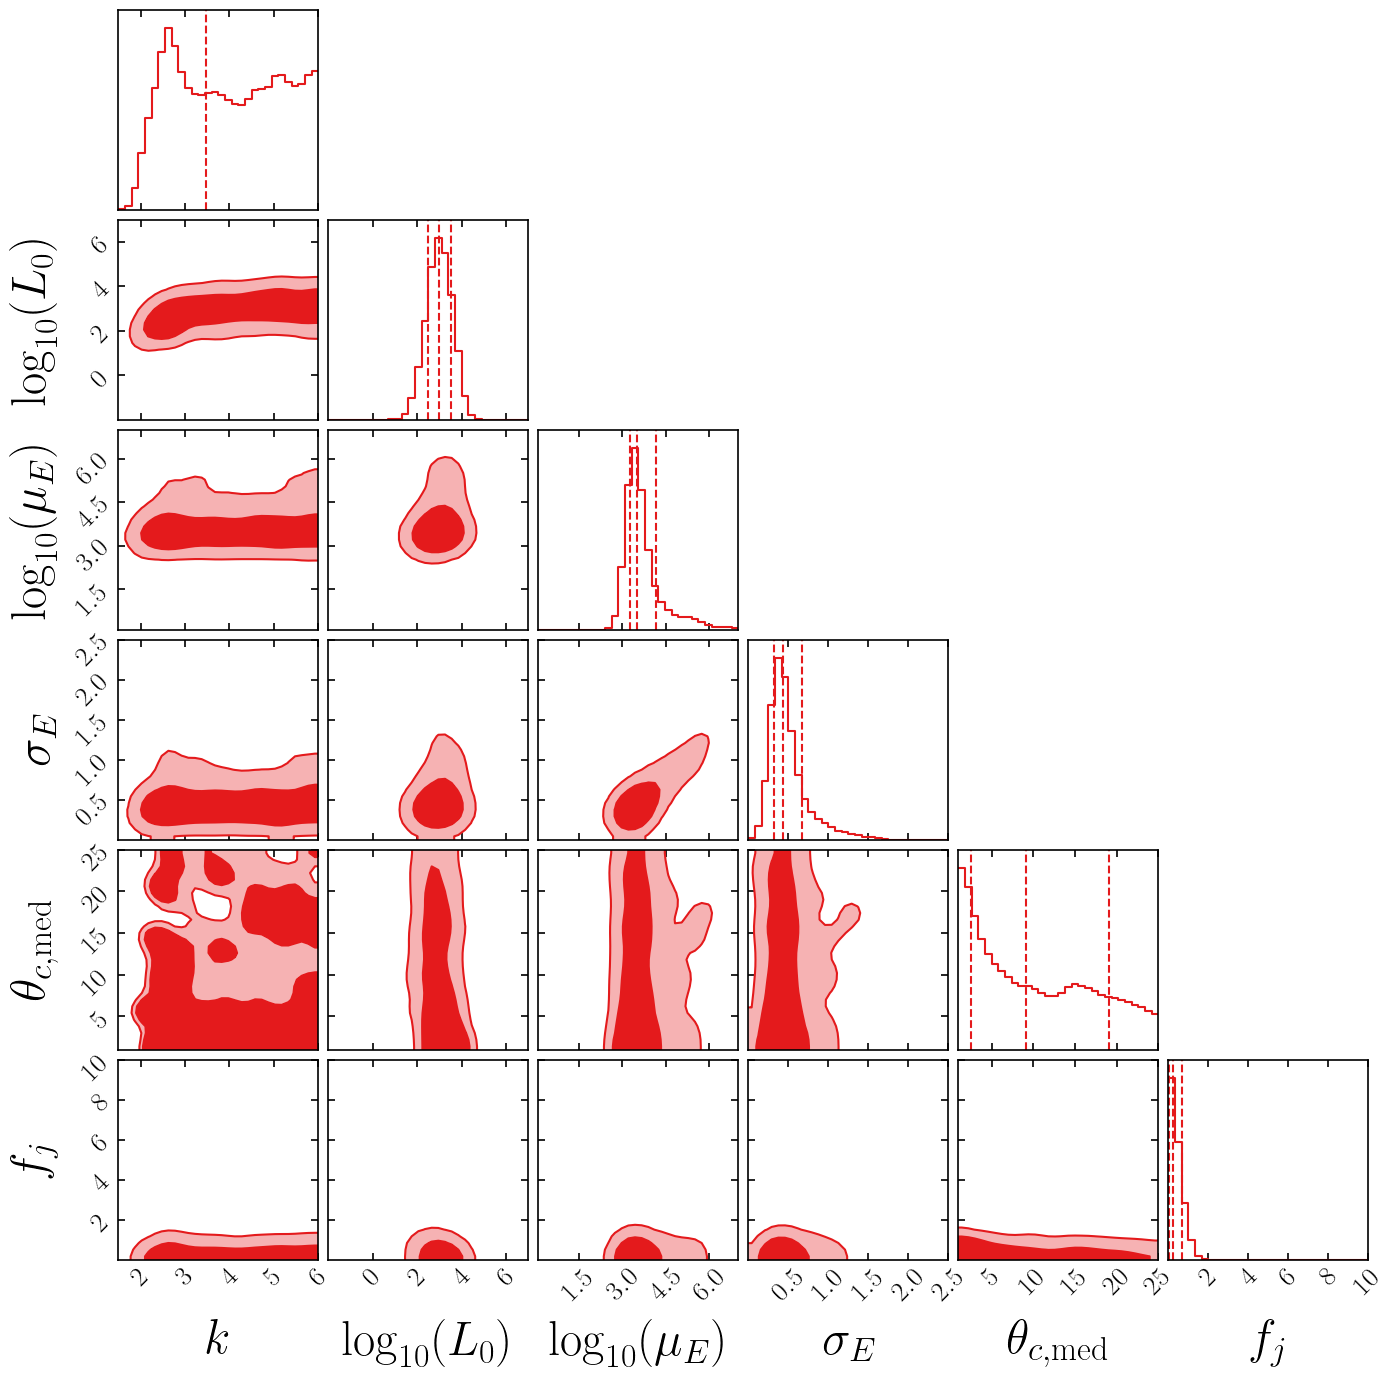

In [7]:
# plot
backend_ln = emcee.backends.HDFBackend(output_dir_lm / "emcee.h5")

plotter_log_normal = TopHatPlotter(
    backend     =   backend_ln,
    output_dir  =   output_dir_lm,
    model_type  =   "lognormal_theta_flat",
    burn_in     =   30_000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_log_normal.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=geom_eff_interp
)

print(summary)  # Print LaTeX table

In [ ]:
1/0

ZeroDivisionError: division by zero

# Multiple Populations

In [8]:
from multiprocessing import Pool
from pathlib import Path
import src.init
from src.spectral_models import DEFAULT_SPECTRAL_PARAMS
population_folder = Path("datafiles") / "populations" / "samples"
#with glob find all the samples_*.dat files
samples         = list(population_folder.glob('samples_*.dat'))
samp_names      = [samp.name.split('samples_')[1].split('_BNSs')[0] for samp in samples]
print(f"Found {len(samples)} samples: {samp_names}")
total_num_samp  = len(samp_names)
datafiles       = Path("datafiles")

Found 64 samples: ['fiducial_delayed_A0.5', 'fiducial_delayed_A1.0', 'fiducial_delayed_A3.0', 'fiducial_delayed_A5.0', 'fiducial_fmtbse_A0.5', 'fiducial_fmtbse_A1.0', 'fiducial_fmtbse_A3.0', 'fiducial_fmtbse_A5.0', 'fiducial_HGoptimistic_A0.5', 'fiducial_HGoptimistic_A1.0', 'fiducial_HGoptimistic_A3.0', 'fiducial_HGoptimistic_A5.0', 'fiducial_Hrad_5M_A0.5', 'fiducial_Hrad_5M_A1.0', 'fiducial_Hrad_5M_A3.0', 'fiducial_Hrad_5M_A5.0', 'fiducial_Hrad_A0.5', 'fiducial_Hrad_A1.0', 'fiducial_Hrad_A3.0', 'fiducial_Hrad_A5.0', 'fiducial_kick150_A0.5', 'fiducial_kick150_A1.0', 'fiducial_kick150_A3.0', 'fiducial_kick150_A5.0', 'fiducial_kick265_A0.5', 'fiducial_kick265_A1.0', 'fiducial_kick265_A3.0', 'fiducial_kick265_A5.0', 'fiducial_klencki_A0.5', 'fiducial_klencki_A1.0', 'fiducial_klencki_A3.0', 'fiducial_klencki_A5.0', 'fiducial_l01_A0.5', 'fiducial_l01_A1.0', 'fiducial_l01_A3.0', 'fiducial_l01_A5.0', 'fiducial_notides_A0.5', 'fiducial_notides_A1.0', 'fiducial_notides_A3.0', 'fiducial_notides_

In [ ]:
n_steps     = 35_020
n_walkers   = 20
burn_in     = 5000  # Burn-in for plotting
thin        = 15

for z_test in samp_names:
    print(f"Processing population: {z_test} ({samp_names.index(z_test)+1}/{total_num_samp})")
    
    # --- Common Setup for this population ---
    params_pop = DEFAULT_SPECTRAL_PARAMS.copy()
    params_pop["z_model"] = z_test

    # Initialize simulation with specific population
    current_params, _, _ = src.init.initialize_simulation(datafiles, params_pop)
    
    # Pre-compute distances and interpolator
    k_interpolator = create_k_interpolator()

    # ==========================================
    # Model 1: LN Flat (Direct sampling) - 6 Parameters
    # ==========================================
    print(f"  >> Running LN Flat model for {z_test}...")
    output_dir_ln_flat = src.init.create_run_dir(f"ProductionPop_LN_Flat/{z_test}", use_timestamp=False)
    filename_ln_flat = output_dir_ln_flat / "emcee.h5"
    
    # Create log prob function for LN Flat model
    log_prob_ln_flat = create_log_probability_function(
        log_prior_func      =  log_prior_log_normal,                    # Uses theta_c_med + f_j
        log_likelihood_func =  log_likelihood_log_normal,               # Uses geometric efficiency for lognormal
        params_in           =  current_params,
        k_interpolator      =  k_interpolator
    )

    # Check resume status
    initial_pos_ln_flat, steps_todo_ln_flat, backend_ln_flat = check_and_resume_mcmc(
        filename                = filename_ln_flat,
        n_steps                 = n_steps,
        initialize_walkers_func = initialize_walkers_log_normal,
        n_walkers               = n_walkers
    )
    
    # Run if needed 
    # Only rerun models with rate < 2 and above 114

    if steps_todo_ln_flat <= 0:
        print(f"     LN Flat model already completed.")
        continue    

    local_rate = current_params.local_rate
    if local_rate < 10:
        print(f"     Skipping LN Flat model for local rate {local_rate:.2f}.")
        continue

    run_mcmc( 
        log_probability_func = log_prob_ln_flat,
        initial_walkers      = initial_pos_ln_flat,
        n_iterations         = steps_todo_ln_flat,
        n_walkers            = n_walkers, 
        n_params             = 6,                        # ← CHANGED FROM 5 TO 6
        backend              = backend_ln_flat,      
    )

    # ==========================================
    # Generate Plots for this population
    # ==========================================
    print(f"  >> Generating plots for {z_test}...")
    
    try:
        # Load backend for plotting
        backend_plot = emcee.backends.HDFBackend(filename_ln_flat, read_only=True)
        
        # Create plotter
        plotter = TopHatPlotter(
            backend     = backend_plot,
            output_dir  = output_dir_ln_flat,
            model_type  = "lognormal_theta_flat",
            burn_in     = burn_in,
            thin        = thin
        )
        
        # Generate all plots
        distances_new = compute_luminosity_distance(current_params.z_arr)
        summary = plotter.generate_all_plots(
            mc_func=simplified_montecarlo,
            params_in=current_params,
            distances=distances_new,
            k_interpolator=k_interpolator,
            geometric_eff_func=geom_eff_interp
        )
        
        # Save summary to file
        with open(output_dir_ln_flat / "summary.txt", "w") as f:
            f.write(summary)
        
        print(f"     Plots saved to {output_dir_ln_flat}")
        
        # Close figures to free memory
        plt.close('all')
        
    except Exception as e:
        print(f"     Warning: Could not generate plots for {z_test}: {e}")

Processing population: fiducial_delayed_A0.5 (1/64)
Using redshift model: samples_fiducial_delayed_A0.5_BNSs_0.dat with 60187 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_delayed_A0.5...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_delayed_A0.5
Continuing from iteration 25000


100%|██████████| 10020/10020 [10:57<00:00, 15.25it/s]


  >> Generating plots for fiducial_delayed_A0.5...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_delayed_A0.5
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_delayed_A0.5
Processing population: fiducial_delayed_A1.0 (2/64)
Using redshift model: samples_fiducial_delayed_A1.0_BNSs_0.dat with 342071 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_delayed_A1.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_delayed_A1.0
Continuing from iteration 25000


100%|██████████| 10020/10020 [10:24<00:00, 16.04it/s]


  >> Generating plots for fiducial_delayed_A1.0...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_delayed_A1.0
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_delayed_A1.0
Processing population: fiducial_delayed_A3.0 (3/64)
Using redshift model: samples_fiducial_delayed_A3.0_BNSs_0.dat with 358417 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_delayed_A3.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_delayed_A3.0
Already completed this run
     LN Flat model already completed.
Processing population: fidu

100%|██████████| 10020/10020 [10:05<00:00, 16.54it/s]


  >> Generating plots for fiducial_fmtbse_A0.5...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A0.5
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A0.5
Processing population: fiducial_fmtbse_A1.0 (6/64)
Using redshift model: samples_fiducial_fmtbse_A1.0_BNSs_0.dat with 233115 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_fmtbse_A1.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A1.0
Continuing from iteration 25000


100%|██████████| 10020/10020 [10:28<00:00, 15.95it/s]


  >> Generating plots for fiducial_fmtbse_A1.0...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A1.0
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A1.0
Processing population: fiducial_fmtbse_A3.0 (7/64)
Using redshift model: samples_fiducial_fmtbse_A3.0_BNSs_0.dat with 283535 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_fmtbse_A3.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A3.0
Already completed this run
     LN Flat model already completed.
Processing population: fiducial_fm

100%|██████████| 10020/10020 [14:41<00:00, 11.37it/s]


  >> Generating plots for fiducial_fmtbse_A5.0...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A5.0
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_fmtbse_A5.0
Processing population: fiducial_HGoptimistic_A0.5 (9/64)
Using redshift model: samples_fiducial_HGoptimistic_A0.5_BNSs_0.dat with 7636 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_HGoptimistic_A0.5...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_HGoptimistic_A0.5
Continuing from iteration 25000
     Skipping LN Flat model for local rate 3.

100%|██████████| 10020/10020 [14:40<00:00, 11.38it/s]


  >> Generating plots for fiducial_HGoptimistic_A1.0...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_HGoptimistic_A1.0
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_HGoptimistic_A1.0
Processing population: fiducial_HGoptimistic_A3.0 (11/64)
Using redshift model: samples_fiducial_HGoptimistic_A3.0_BNSs_0.dat with 361335 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_HGoptimistic_A3.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_HGoptimistic_A3.0
Already completed this run
     LN Flat model already co

100%|██████████| 10020/10020 [14:14<00:00, 11.73it/s]


  >> Generating plots for fiducial_Hrad_5M_A0.5...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_Hrad_5M_A0.5
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_Hrad_5M_A0.5
Processing population: fiducial_Hrad_5M_A1.0 (14/64)
Using redshift model: samples_fiducial_Hrad_5M_A1.0_BNSs_0.dat with 359531 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_Hrad_5M_A1.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_Hrad_5M_A1.0
Continuing from iteration 25000


100%|██████████| 10020/10020 [14:06<00:00, 11.83it/s]


  >> Generating plots for fiducial_Hrad_5M_A1.0...
Generating corner plot...
(40020, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/ProductionPop_LN_Flat/fiducial_Hrad_5M_A1.0
     Plots saved to Output_files/ProductionPop_LN_Flat/fiducial_Hrad_5M_A1.0
Processing population: fiducial_Hrad_5M_A3.0 (15/64)
Using redshift model: samples_fiducial_Hrad_5M_A3.0_BNSs_0.dat with 370949 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running LN Flat model for fiducial_Hrad_5M_A3.0...
Loading existing directory  : Output_files/ProductionPop_LN_Flat/fiducial_Hrad_5M_A3.0
Already completed this run
     LN Flat model already completed.
Processing population: fid

  1%|          | 65/10020 [00:04<12:29, 13.28it/s]


KeyboardInterrupt: 

In [ ]:
1/0

ZeroDivisionError: division by zero

# Plotting the multiple populations

In [9]:
%load_ext autoreload
%autoreload 2

from src.plots_oop_epsilon import ThetaCModelPlotter, FjModelPlotter, LogNormalModelPlotter
from src.top_hat.geometric_eff import (
    geometric_efficiency_fixed,
    geometric_efficiency_flat,
    create_geometric_efficiency_lognormal_interpolator
)  
from pathlib import Path
plt.style.use('./configurations/style.mplstyle')

population_folder       = Path("datafiles") / "populations" / "samples"
samples                 = list(population_folder.glob('samples_*.dat'))
SAMP_NAMES              = [samp.name.split('samples_')[1].split('_BNSs')[0] for samp in samples]
DATA_FILES_DIR          = Path("datafiles")
print(f"Found {len(samples)} samples: {SAMP_NAMES}")
beaming_theta_c     = geometric_efficiency_fixed
beaming_efficiency  = geometric_efficiency_flat
geom_eff_lognormal  = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 64 samples: ['fiducial_delayed_A0.5', 'fiducial_delayed_A1.0', 'fiducial_delayed_A3.0', 'fiducial_delayed_A5.0', 'fiducial_fmtbse_A0.5', 'fiducial_fmtbse_A1.0', 'fiducial_fmtbse_A3.0', 'fiducial_fmtbse_A5.0', 'fiducial_HGoptimistic_A0.5', 'fiducial_HGoptimistic_A1.0', 'fiducial_HGoptimistic_A3.0', 'fiducial_HGoptimistic_A5.0', 'fiducial_Hrad_5M_A0.5', 'fiducial_Hrad_5M_A1.0', 'fiducial_Hrad_5M_A3.0', 'fiducial_Hrad_5M_A5.0', 'fiducial_Hrad_A0.5', 'fiducial_Hrad_A1.0', 'fiducial_Hrad_A3.0', 'fiducial_Hrad_A5.0', 'fiducial_kick150_A0.5', 'fiducial_kick150_A1.0', 'fiducial_kick150_A3.0', 'fiducial_kick150_A5.0', 'fiducial_kick265_A0.5', 'fiducial_kick265_A1.0', 'fiducial_kick265_A3.0', 'fiducial_kick265_A5.0', 'fiducial_klencki_A0.5', 'fiducial_klencki_A1.0', 'fiducial_klencki_A3.0', 'fiducial_klencki_A5.0', 'fiducial_l01_A0.5', 'fiducial_l01_A1.0', 'fiducial_l01_A3.0', 'fiducial_l01_A5.0', 'fidu

In [10]:
# For Theta_c models (6 parameters)
run_name_c            = "ProductionPop_Theta_c_10k"
BASE_DIR_THETA_C        = Path(run_name_c)
OUTPUT_DIR_THETA_C      = Path("Output_files") / run_name_c
OUTPUT_DIR_THETA_C.mkdir(parents=True, exist_ok=True)

plotter_theta_c = ThetaCModelPlotter(
    samp_names=     SAMP_NAMES,
    base_dir=       str(BASE_DIR_THETA_C),
    data_files_dir= str(DATA_FILES_DIR),
    output_dir  =   str(OUTPUT_DIR_THETA_C),
    discard     =   1000,
    thin        =   20,
    k_params    =   6,
    theta_c_idx =   4,  # Index of theta_c in degrees
    fj_idx      =   5,       # Index of fj in parameter array
    fontsize    =   20
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_Theta_c_10k/theta_star_robust_vs_rate.pdf


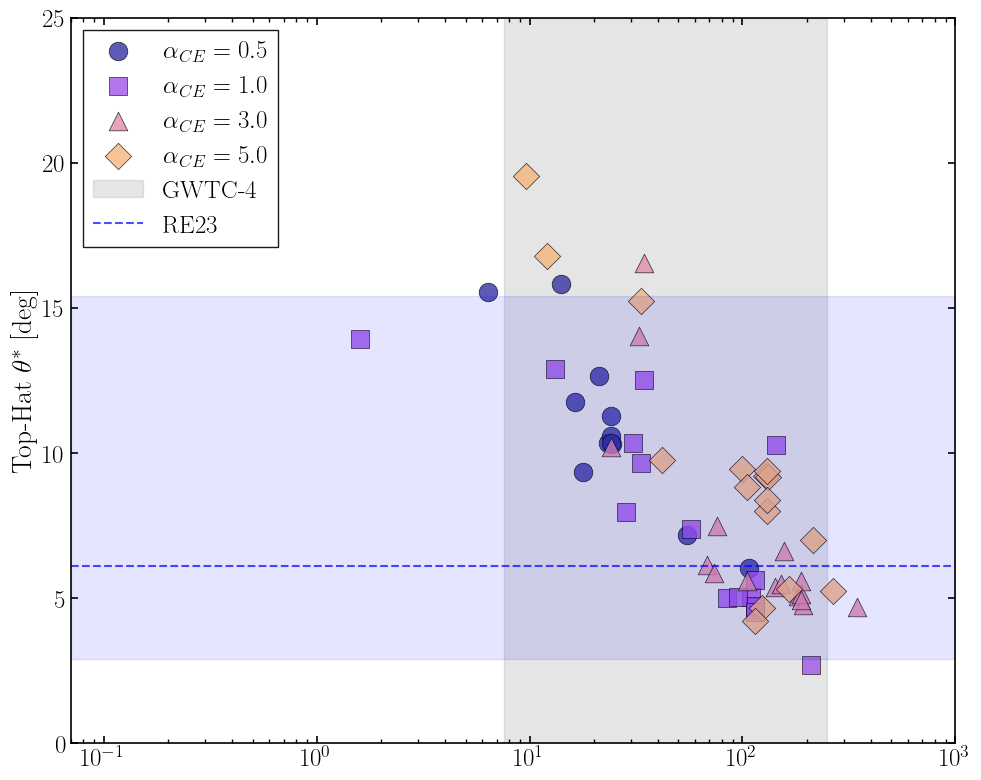

In [11]:
out = plotter_theta_c.plot_theta_star_robust_vs_rate(
    beaming_func=beaming_theta_c, 
    legend_flag=True)

Saved plot to Output_files/ProductionPop_Theta_c_10k/fj_fixed.pdf


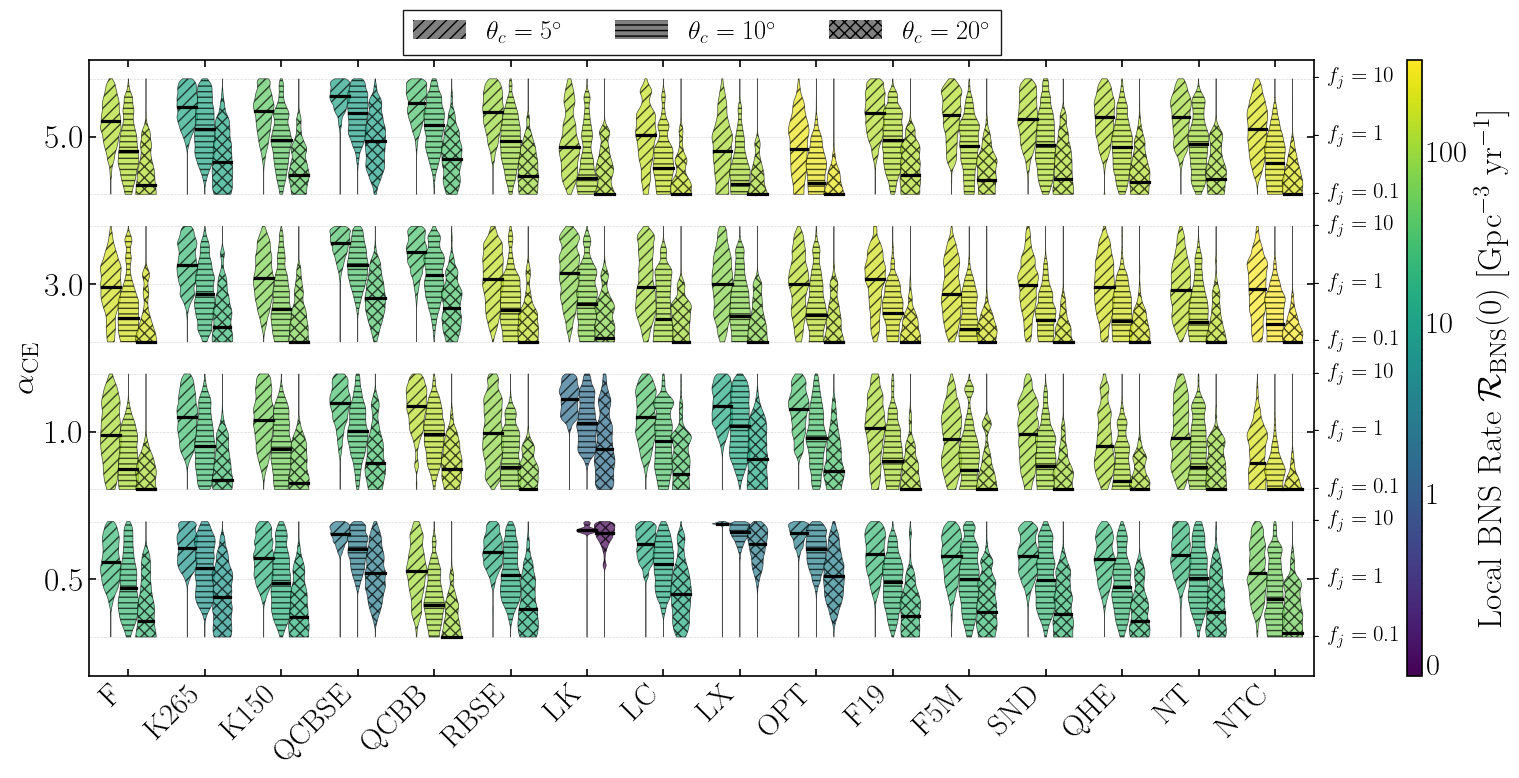

In [12]:
plotter_theta_c.fontsize = 24
plotter_theta_c.plot_violins_fj_at_fixed_angles()
plotter_theta_c.fontsize = 20

Saved plot to Output_files/ProductionPop_Theta_c_10k/epsilon_violin_plot.pdf


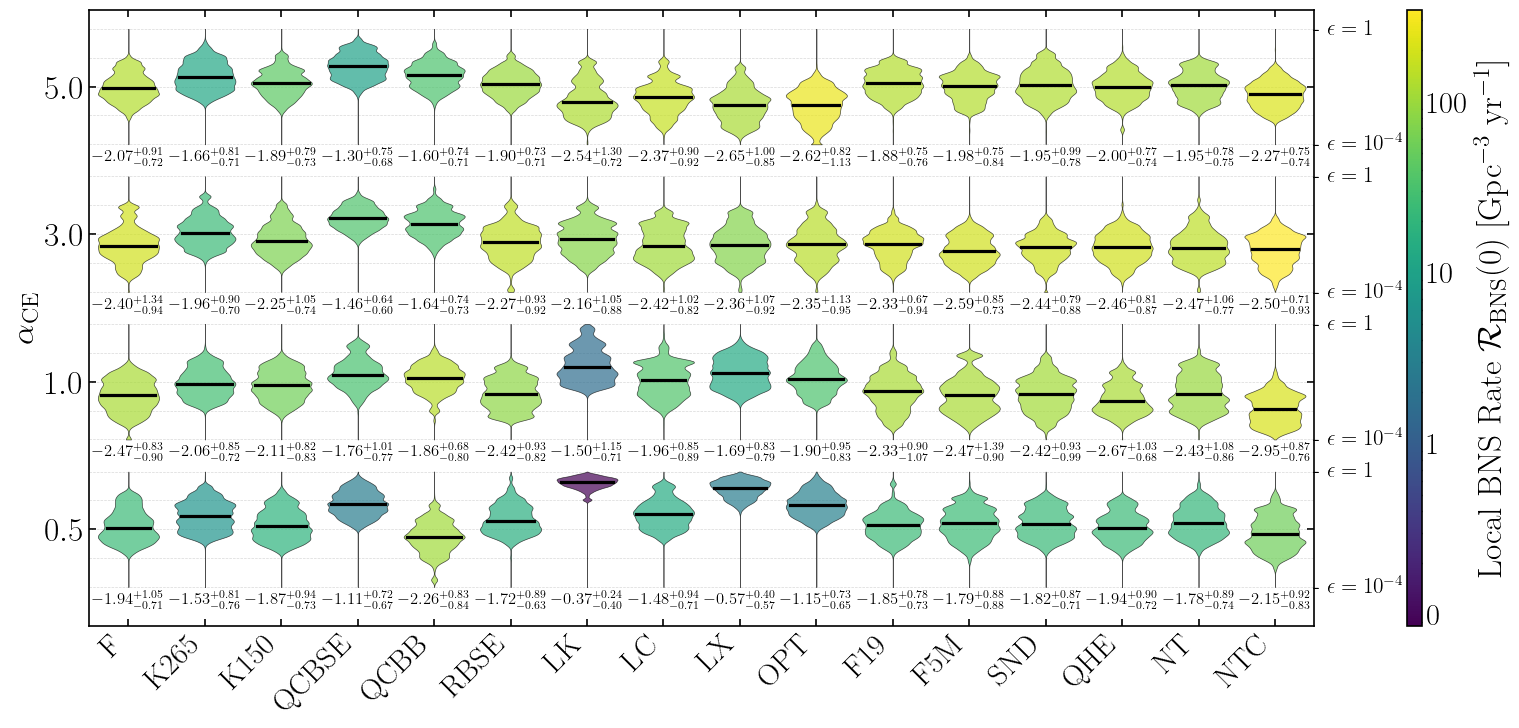

In [13]:
plotter_theta_c.fontsize = 24
plotter_theta_c.plot_violins_epsilon()
plotter_theta_c.fontsize = 20

Saved plot to Output_files/ProductionPop_Theta_c_10k/fj_fraction_vs_rate.pdf


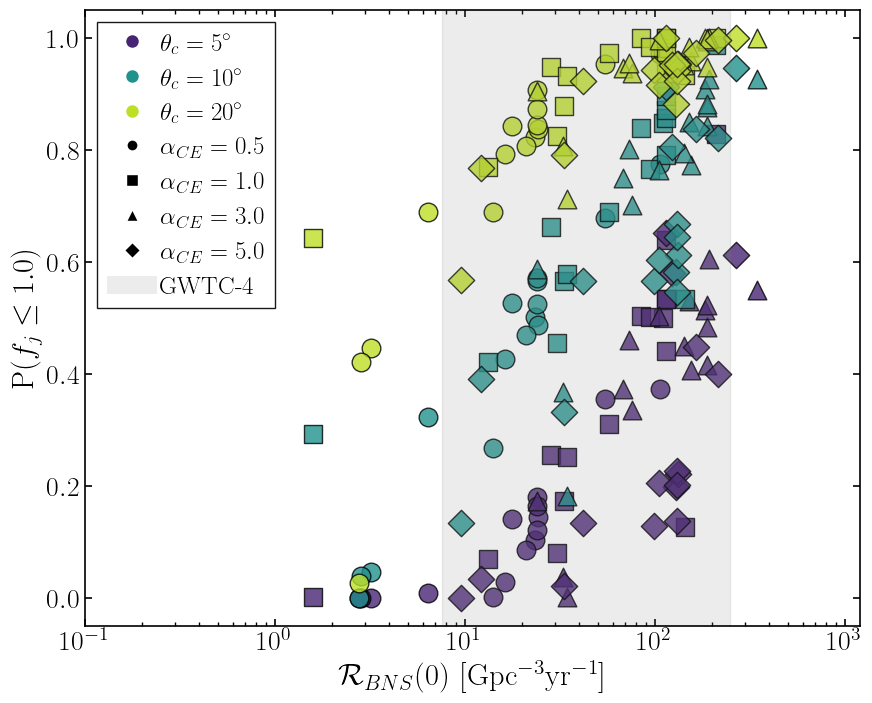

In [14]:
plotter_theta_c.fontsize = 22
plotter_theta_c.plot_fj_fraction_vs_rate()

In [15]:
# For Flat Theta models (6 parameters)
run_name_fj         = "ProductionPop_Flat_10k_new_new"
BASE_DIR_FLAT       = Path(run_name_fj)  # Make sure this is the flat theta directory
OUTPUT_DIR_FLAT     = Path("Output_files") / run_name_fj
OUTPUT_DIR_FLAT.mkdir(parents=True, exist_ok=True)

# For Flat Theta models (6 parameters)
plotter_fj = FjModelPlotter(
    samp_names  =   SAMP_NAMES,
    base_dir    =   str(BASE_DIR_FLAT),
    data_files_dir  =str(DATA_FILES_DIR),
    output_dir  =   str(OUTPUT_DIR_FLAT),
    discard     =   5000,
    thin        =   20,
    k_params    =   6,
    theta_c_idx =   4,          # Index of theta_c in parameter array
    fj_idx      =   5,          # Index of fj in parameter array
)

Loading and processing model data...
Successfully processed 64 models.


No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
Saved plot to Output_files/ProductionPop_Flat_10k_new_new/theta_star_robust_vs_rate.pdf


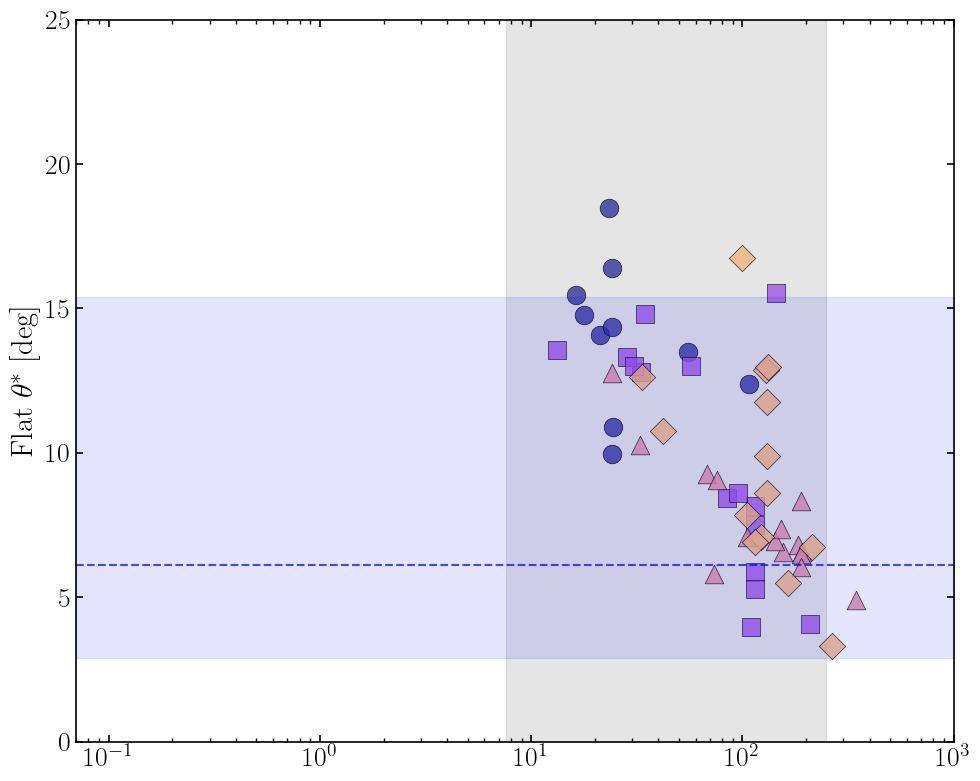

In [16]:
out = plotter_fj.plot_theta_star_robust_vs_rate(
    label_flag=1, 
    beaming_func=beaming_efficiency
)

In [17]:
run_name = "ProductionPop_LN_Flat"
BASE_DIR_LN = Path(run_name)
OUTPUT_DIR_LN = Path("Output_files") / run_name
OUTPUT_DIR_LN.mkdir(parents=True, exist_ok=True)

plotter_ln  = LogNormalModelPlotter(
    samp_names          =   SAMP_NAMES,
    base_dir            =   str(BASE_DIR_LN),
    data_files_dir      =   str(DATA_FILES_DIR),
    output_dir          =   str(OUTPUT_DIR_LN),
    discard             =   3000,
    thin                =   15,
    k_params            =   6,
    theta_c_idx         =   4,  
    fj_idx              =   5,
    fontsize            =   20
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_LN_Flat/theta_star_robust_vs_rate.pdf


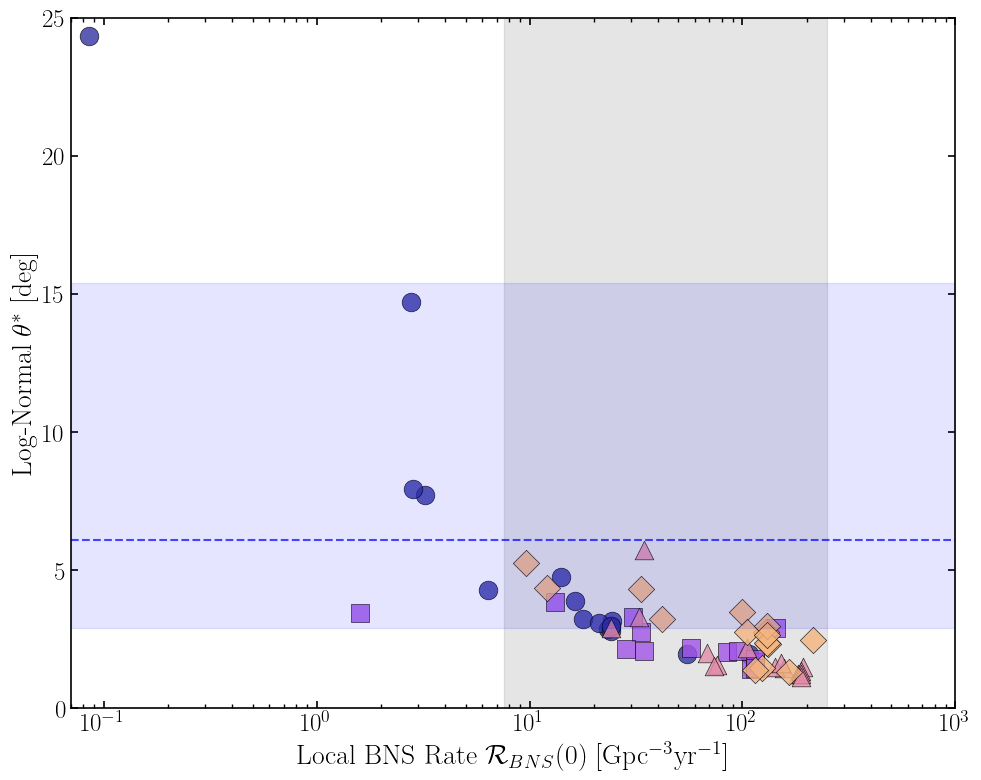

In [18]:
out = plotter_ln.plot_theta_star_robust_vs_rate(
    beaming_func=geom_eff_lognormal,
    label_flag=2,
    xlabel=True,
)

No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.


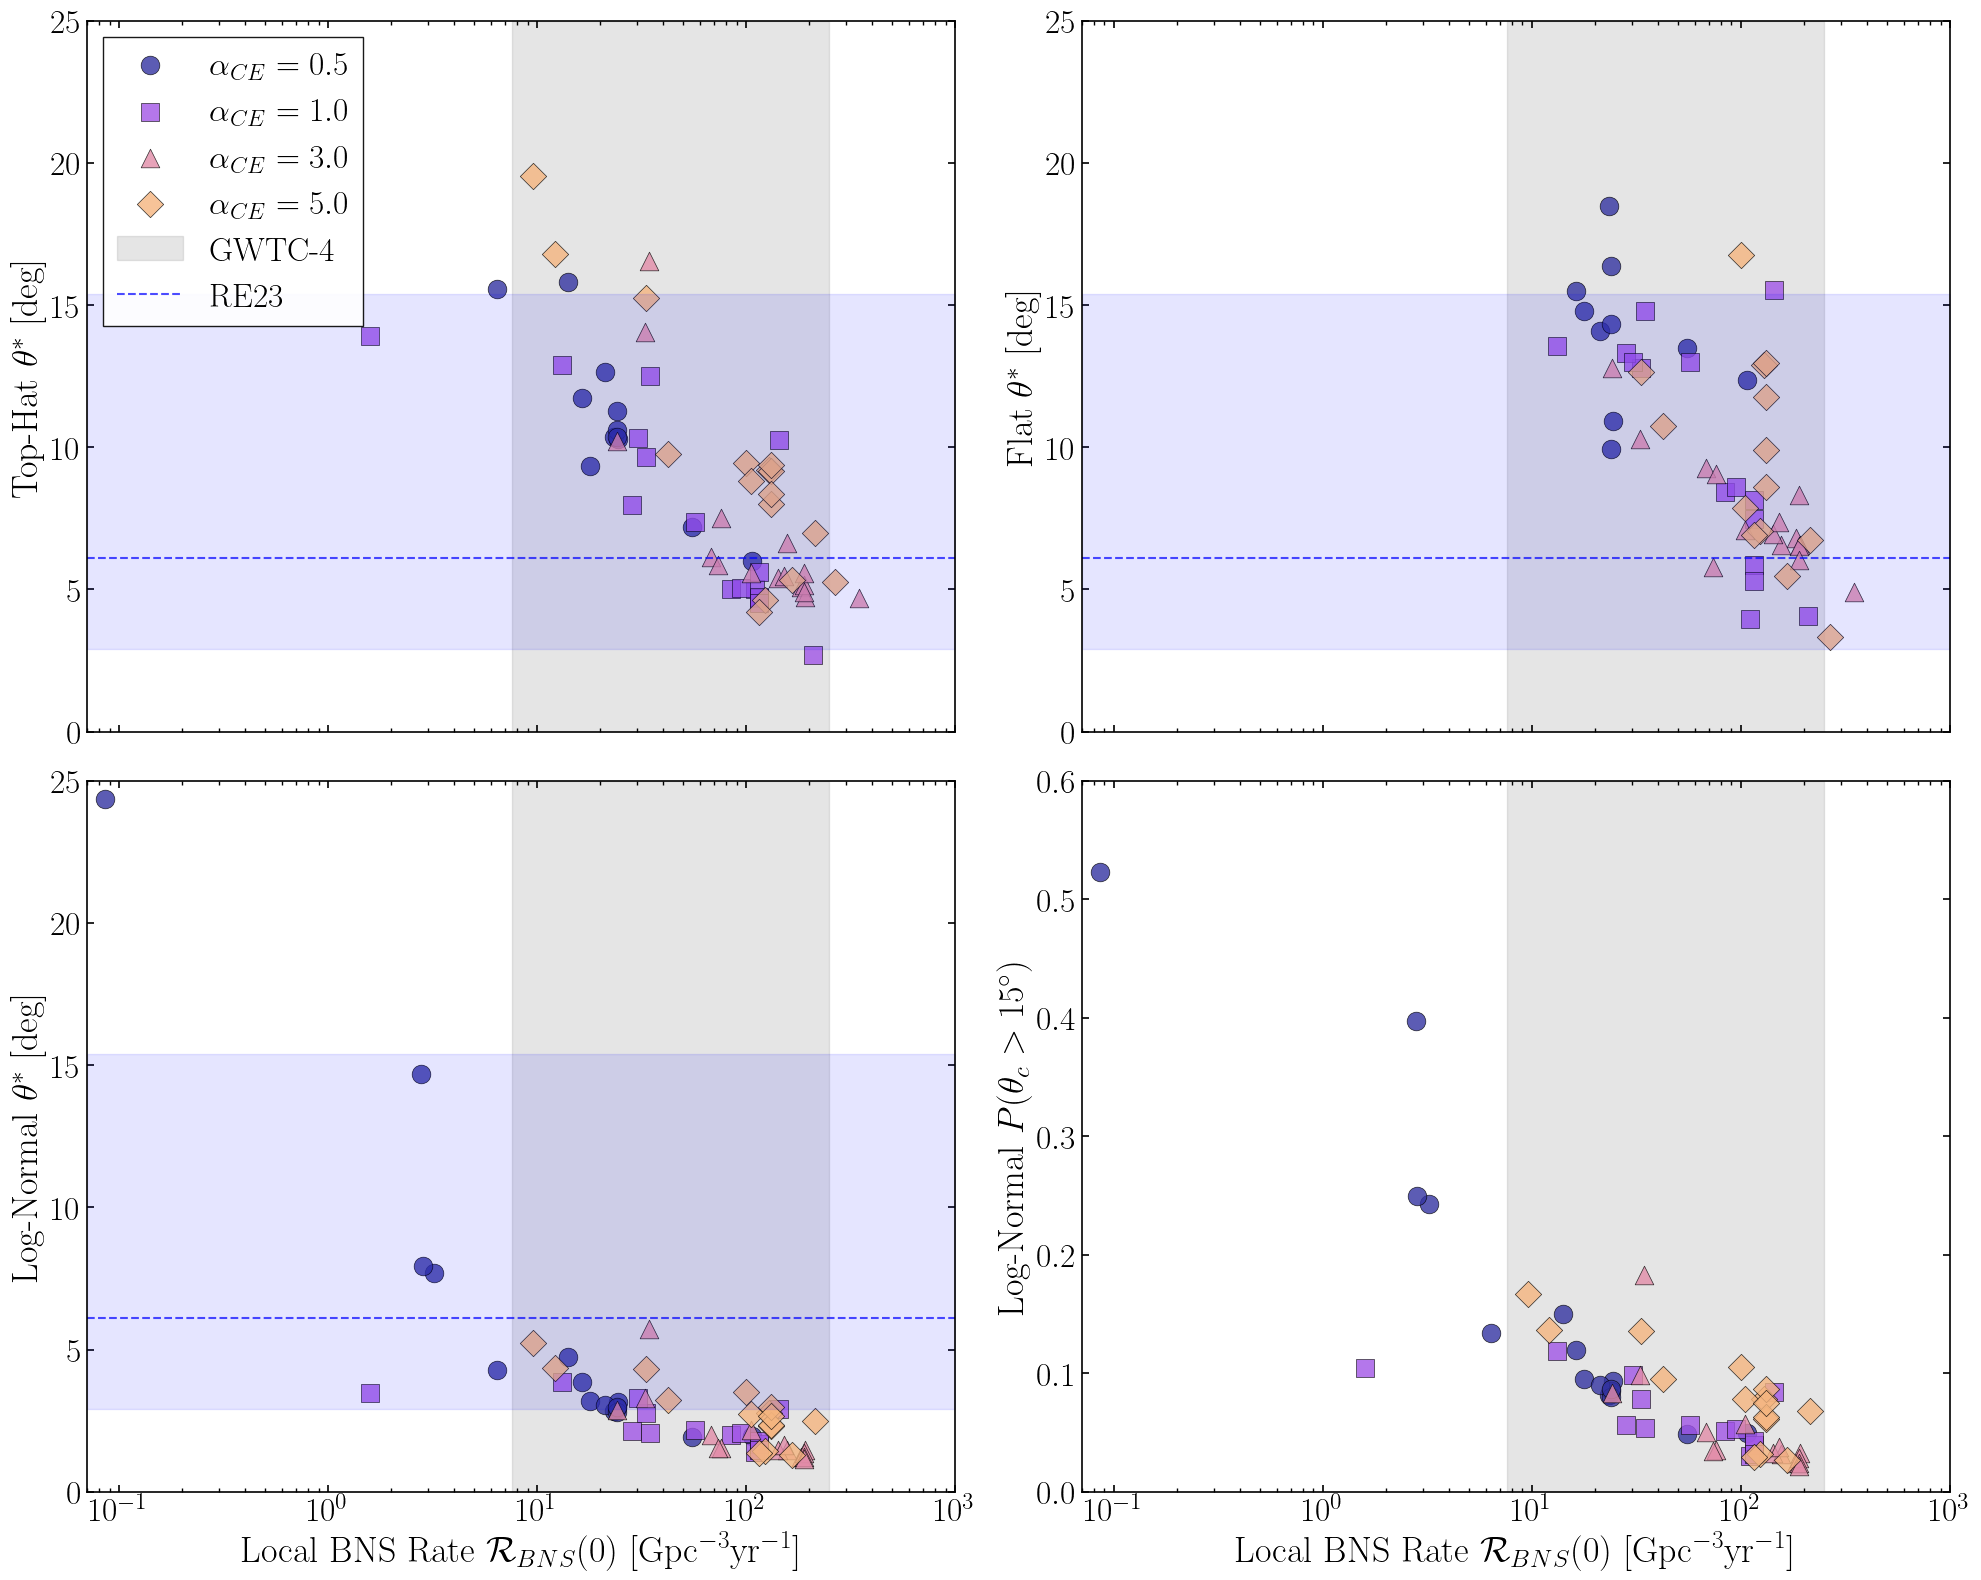

In [19]:
import matplotlib.pyplot as plt
FS = 24
plotter_fj.fontsize = FS
plotter_theta_c.fontsize = FS
plotter_ln.fontsize = FS

# 1. Create the Shared Figure
fig, axes = plt.subplots(2, 2, figsize=(20, 16)) # Adjust figsize as needed
((ax1, ax2), (ax3, ax4)) = axes  # Unpack the axes

plotter_fj.fontsize = 26
plotter_theta_c.fontsize = 26
plotter_ln.fontsize = 26

plotter_theta_c.plot_theta_star_robust_vs_rate(
    beaming_func=beaming_theta_c, 
    legend_flag=True,
    ax=ax1  # <--- Pass the axis
)

plotter_fj.plot_theta_star_robust_vs_rate(
    label_flag=1, 
    beaming_func=beaming_efficiency,
    ax=ax2
)

plotter_ln.plot_theta_star_robust_vs_rate(
    label_flag=2,
    beaming_func=geom_eff_lognormal,
    xlabel=True,
    ax=ax3
)

plotter_ln.plot_lognormal_tail_fraction_vs_rate(
    beaming_func=geom_eff_lognormal, 
    xlabel=True,
    ax=ax4
)

# remove the xtick labels from the top row
ax1.set_xticklabels([])
ax2.set_xticklabels([])

plt.tight_layout()
plt.savefig("combined_2x2_plot.pdf", bbox_inches='tight')
plt.show()

No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.


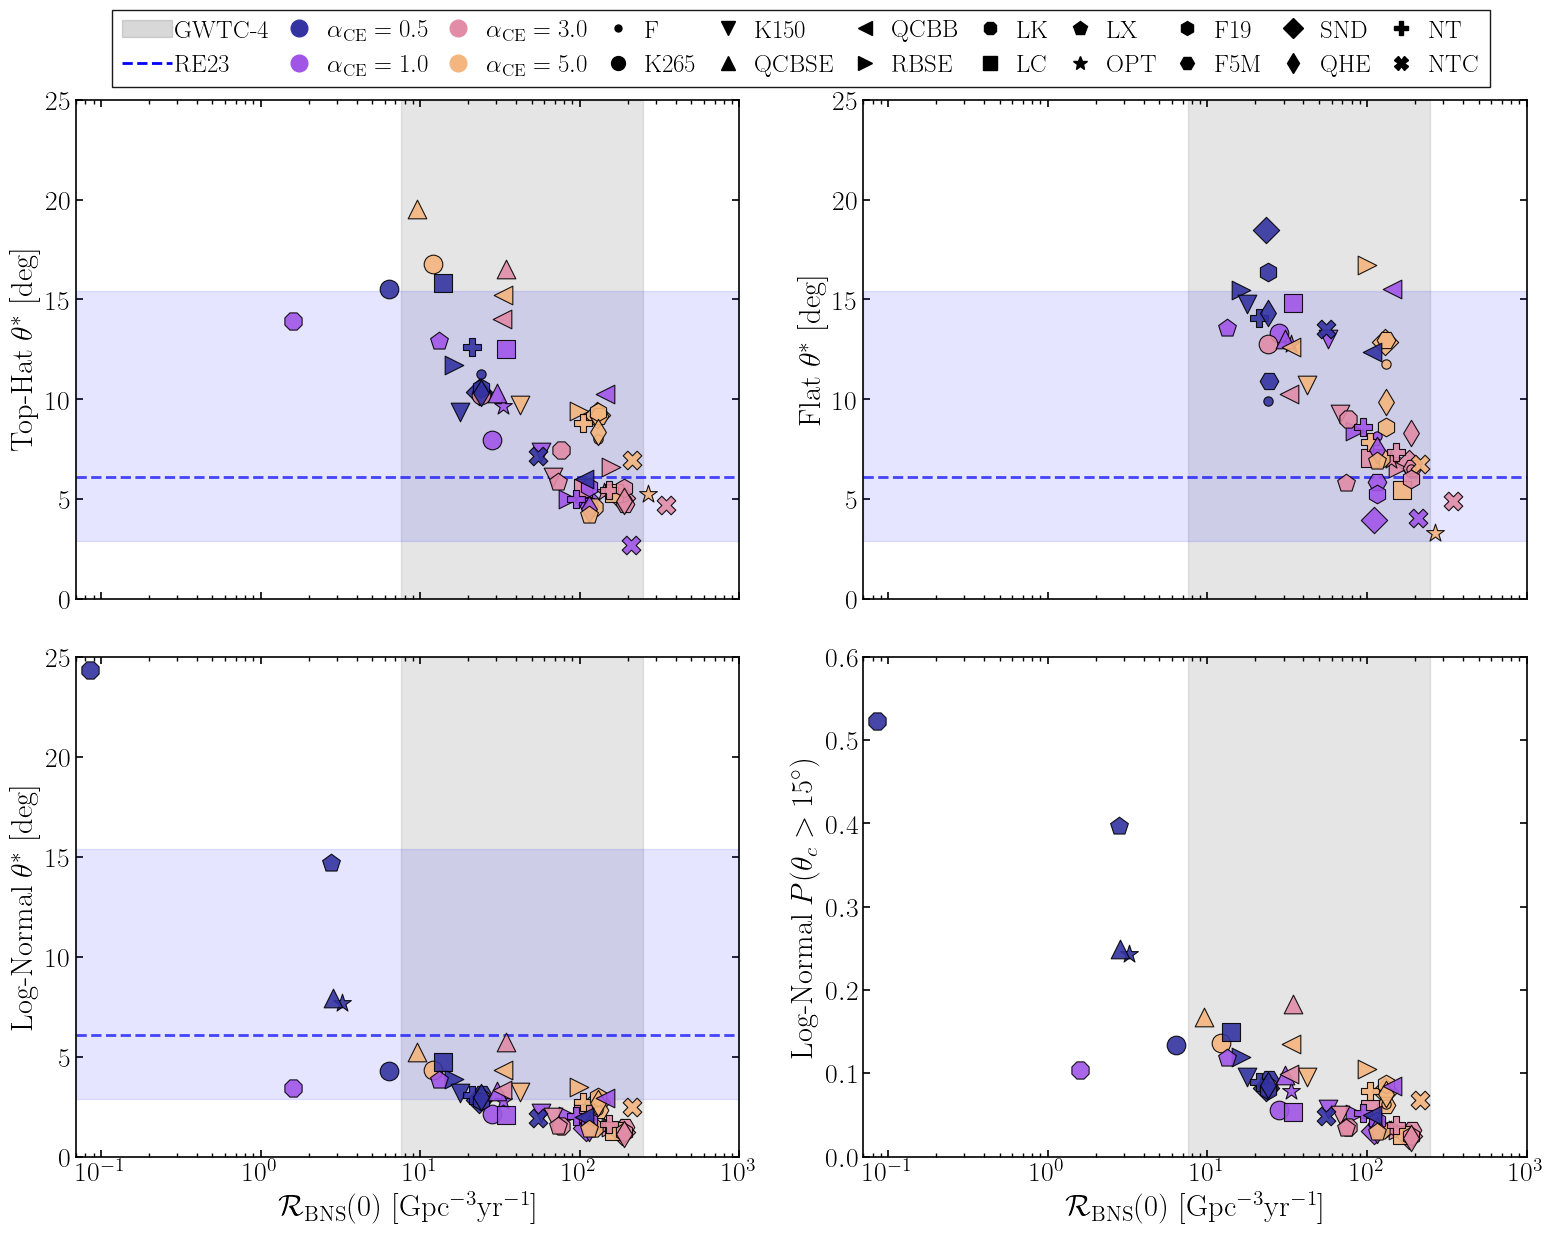

In [23]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import lognorm

# --- Configuration ---
FS = 22
plt.rcParams.update({'font.size': FS})
MARKERS = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'h', 'H', '*', 'X', 'P', '8', 'd', '.']

MARKERS =  mlines.Line2D.filled_markers
COLORS = ["#3333a1", "#a155e7", "#e28ca8", "#f5b57f"] # Your specific Alpha colors

# Get unique models and alphas to build consistent maps
all_data_ref = plotter_theta_c.model_data # Assuming all plotters have same models
ordered_model_dict = {
  "fiducial_Hrad": "F",
  "fiducial_kick265": "K265",
  "fiducial_kick150": "K150",
  "fiducial_qcbse": "QCBSE",
  "fiducial_rad": "QCBB",
  "fiducial_fmtbse": "RBSE",
  "fiducial_klencki": "LK",
  "fiducial_l01": "LC",
  "fiducial_xuli": "LX",
  "fiducial_HGoptimistic": "OPT",
  "fiducial_pisnfarmer19": "F19",
  "fiducial_Hrad_5M": "F5M",
  "fiducial_delayed": "SND",
  "fiducial_qhe": "QHE",
  "fiducial_notides": "NT",
  "fiducial_notides_pericirc": "NTC"
}

#models = list(ordered_model_dict.values())
#unique_models = models
#unique_models_ = sorted(list(set(d["name"] for d in all_data_ref)))

unique_models = ordered_model_dict.keys()
#unique_models = [ordered_model_dict[m] for m in unique_models if m in ordered_model_dict]
#print("Unique models found:", unique_models, unique_models_)
unique_alphas = sorted(list(set(d["alpha"] for d in all_data_ref)))

# Create Styling Maps
model_marker_map = {m: MARKERS[i % len(MARKERS)] for i, m in enumerate(unique_models)}
alpha_color_map = {a: COLORS[i % len(COLORS)] for i, a in enumerate(unique_alphas)}

# --- Helper Function for Consistent Plotting ---
def plot_scatter_dataset(ax, plotter_instance, y_calc_func, xlabel=False, ylabel=None):
    """
    Generic function to plot data with the specific Model=Marker / Alpha=Color scheme.
    y_calc_func: function(data_entry) -> returns y_value or np.nan
    """
    # Plot Points
    for data in plotter_instance.model_data:
        if np.isnan(data["rate"]): continue
        
        y_val = y_calc_func(data)
        
        if np.isnan(y_val): continue
        
        c = alpha_color_map[data["alpha"]]
        m = model_marker_map[data["name"]]
        
        ax.scatter(
            data["rate"], y_val,
            c=[c], marker=m, s=180, alpha=0.9, 
            edgecolors='k', linewidth=0.8, zorder=5
        )

    # --- Standard Stylings (GWTC-4, RE23) ---
    # GWTC-4 Vertical Band
    ax.axvspan(7.6, 250, alpha=0.2, color='gray', zorder=0)
    
    # RE23 Horizontal constraint (Only for Theta* plots, approx check based on label)
    if ylabel and "theta" in ylabel.lower():
        # Using values from your provided BasePlotter code
        ax.axhline(y=6.1, linestyle='--', alpha=0.7, color='blue', lw=2)
        ax.fill_betweenx(y=[6.1-3.2, 6.1+9.3], x1=0.07, x2=2000, color='blue', alpha=0.1)
        ax.set_ylim(0, 25)
    
    ax.set_xscale('log')
    ax.set_xlim(0.07, 1000)
    
    ax.tick_params(axis='both', which='major', labelsize=FS-2, direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='minor', direction='in', top=True, right=True)
    
    if xlabel:
        ax.set_xlabel(r'$\mathcal{R}_{\text{BNS}}(0)$ [Gpc$^{-3}$yr$^{-1}$]', fontsize=FS)
    else:
        ax.set_xticklabels([]) # Hide x labels for top row
        
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=FS)

# --- Define Y-Calculation Functions ---

def get_theta_star_theta_c(data):
    # Wrapper for Theta C Plotter
    t, _, _ = plotter_theta_c.calculate_theta_star_from_beaming(
        data["theta_c_samples"], data["fj_samples"], 
        beaming_func=beaming_theta_c, boundary_limit=9.0
    )
    return t

def get_theta_star_fj(data):
    # Wrapper for Fj Plotter (Top-Hat/Flat)
    t, _, _ = plotter_fj.calculate_theta_star_from_beaming(
        data["theta_c_samples"], data["fj_samples"], 
        beaming_func=beaming_efficiency, boundary_limit=9.0
    )
    # Your original code shifted the result for this specific plot: (theta + 1)/2
    if not np.isnan(t):
        return (t + 1) / 2
    return np.nan

def get_theta_star_ln(data):
    # Wrapper for LogNormal Plotter
    t, _, _ = plotter_ln.calculate_theta_star_from_beaming(
        data["theta_c_samples"], data["fj_samples"], 
        beaming_func=geom_eff_lognormal, boundary_limit=9.0
    )
    return t

def get_tail_fraction(data):
    # Logic extracted from plot_lognormal_tail_fraction_vs_rate
    # 1. Get Theta Star
    theta_star, _, _ = plotter_ln.calculate_theta_star_from_beaming(
        data["theta_c_samples"], data["fj_samples"], 
        beaming_func=geom_eff_lognormal
    )
    if np.isnan(theta_star): return np.nan
    
    # 2. Calculate LogNormal Params
    cut_deg = 15.0
    sigma_log10 = 0.5
    s = sigma_log10 * np.log(10)
    t_min, t_max = 1.0, 45.0
    scale = theta_star
    
    # 3. Calculate Fraction
    cdf_total = lognorm.cdf(t_max, s=s, scale=scale) - lognorm.cdf(t_min, s=s, scale=scale)
    if cdf_total <= 0: return np.nan
    
    if cut_deg >= t_max: return 0.0
    
    cdf_above = lognorm.cdf(t_max, s=s, scale=scale) - lognorm.cdf(max(cut_deg, t_min), s=s, scale=scale)
    return cdf_above / cdf_total

# --- Main Plotting Execution ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
((ax1, ax2), (ax3, ax4)) = axes

# 1. Top Left: Theta C (Standard)
plot_scatter_dataset(ax1, plotter_theta_c, get_theta_star_theta_c, 
                     ylabel=r'Top-Hat $\theta^*$ [deg]')

# 2. Top Right: Fj (Flat)
plot_scatter_dataset(ax2, plotter_fj, get_theta_star_fj, 
                     ylabel=r'Flat $\theta^*$ [deg]')

# 3. Bottom Left: LogNormal Theta*
plot_scatter_dataset(ax3, plotter_ln, get_theta_star_ln, 
                     xlabel=True, ylabel=r'Log-Normal $\theta^*$ [deg]')

# 4. Bottom Right: LogNormal Tail Fraction
plot_scatter_dataset(ax4, plotter_ln, get_tail_fraction, 
                     xlabel=True, ylabel=r'Log-Normal $P(\theta_c > 15^\circ)$')
ax4.set_ylim(0, 0.6) # Tail fraction specific limit

# Reference Handles
gwtc_handle = mpatches.Patch(color='gray', alpha=0.3, label='GWTC-4')
re23_handle = mlines.Line2D([], [], color='blue', linestyle='--', linewidth=2, label='RE23')

# Alpha Handles (Colored Circles)
alpha_handles = []
for alpha in unique_alphas:
    # Formatting alpha label (assuming "a01" -> "0.1")
    label_str = rf"$\alpha_{{\mathrm{{CE}}}} = {alpha[1:]}$"
    h = mlines.Line2D([], [], color=alpha_color_map[alpha], marker='o', 
                      ls='None', ms=12, label=label_str)
    alpha_handles.append(h)

# Model Handles (Black markers)
model_handles = []
for model in unique_models:
    # Use dictionary from plotter if available, else raw name
    name_str = plotter_theta_c.model_dic.get(model, model)
    h = mlines.Line2D([], [], color='k', marker=model_marker_map[model], 
                      ls='None', ms=10, label=name_str)
    model_handles.append(h)

# Combine Handles
# Layout: [Refs] [Alphas] ... [Models]
all_handles = [gwtc_handle, re23_handle] + alpha_handles + model_handles

fig.legend(handles=all_handles, loc='upper center', 
           bbox_to_anchor=(0.515, 1.05), # Push slightly above the figure
           ncol=11, 
           fontsize=FS-4, 
           columnspacing=0.2,
           handletextpad=0.11)

plt.tight_layout()
plt.savefig("combined_2x2_plot_16markers.pdf", bbox_inches='tight', dpi=300)
plt.show()

No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.
No valid samples found within boundary limit.


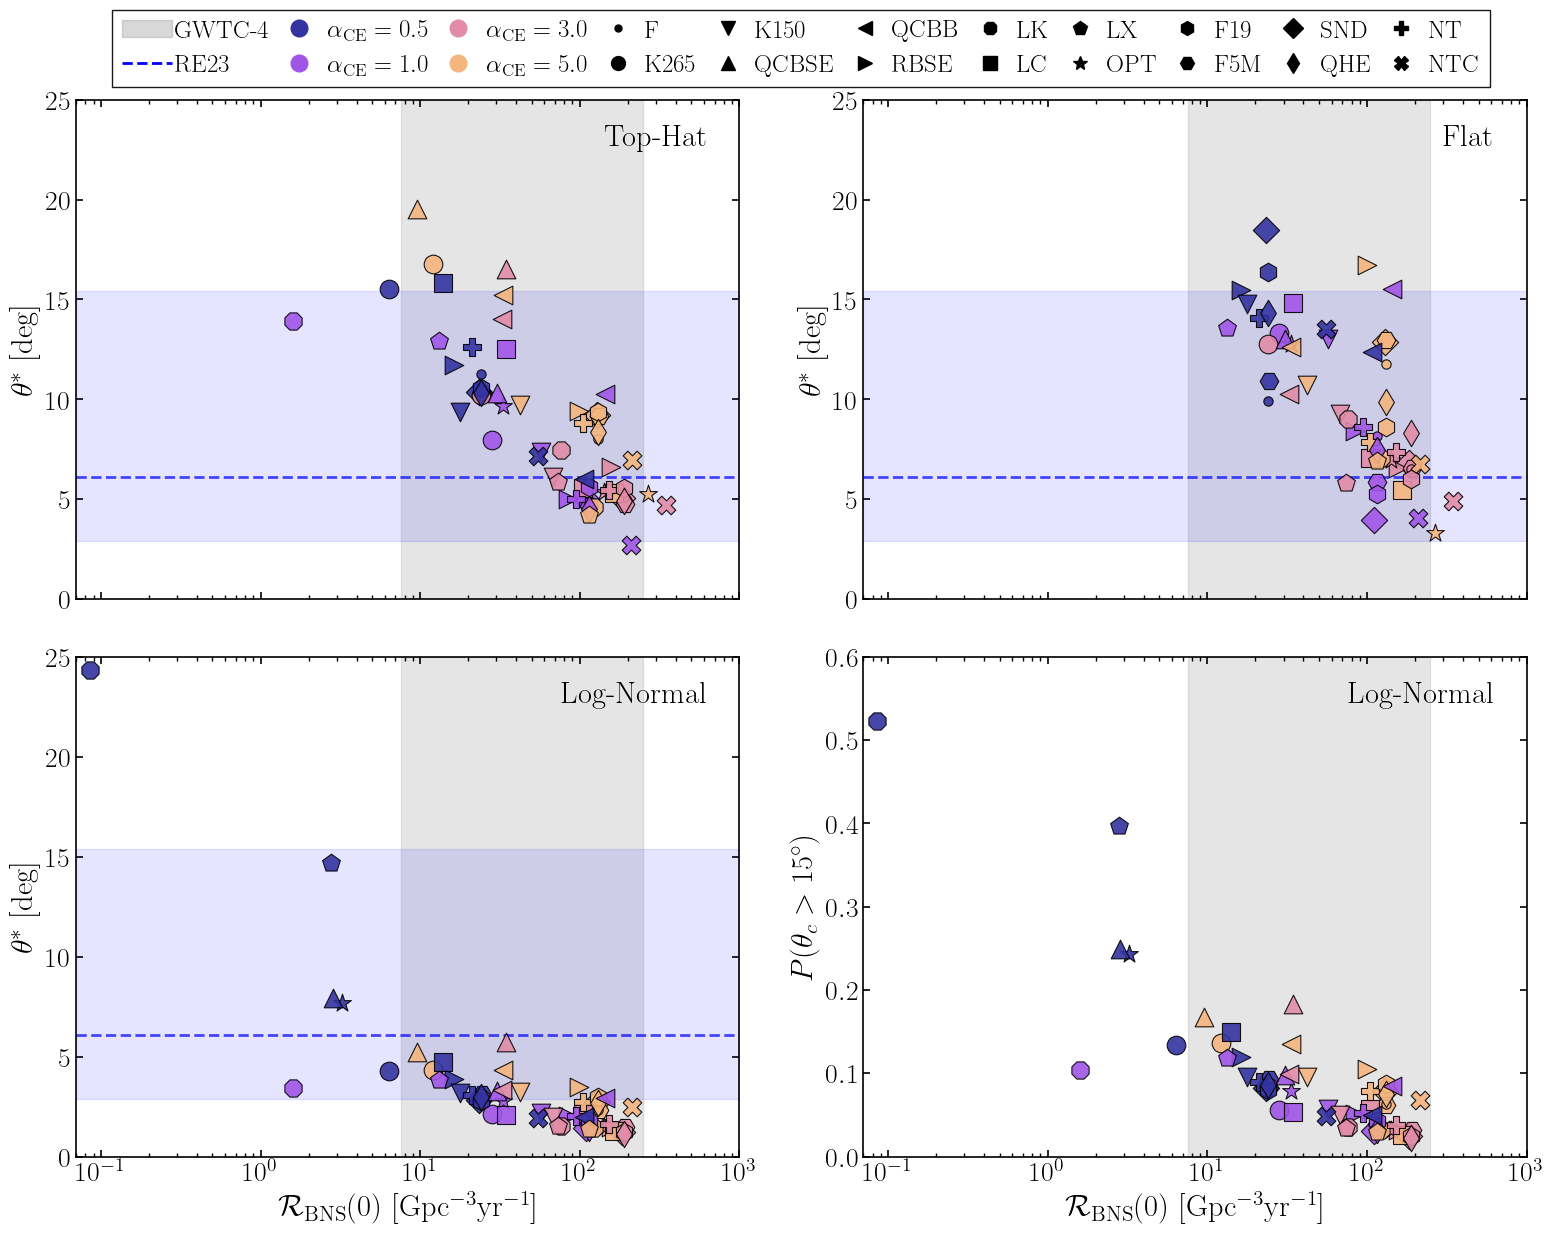

In [29]:
# --- Main Plotting Execution ---

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
((ax1, ax2), (ax3, ax4)) = axes

text_kargs = {
    'fontsize': FS,
    'verticalalignment': 'top',
    'horizontalalignment': 'right',
    'in_layout': False}

# 1. Top Left: Theta C (Standard)
plot_scatter_dataset(ax1, plotter_theta_c, get_theta_star_theta_c, 
                     ylabel=r'$\theta^*$ [deg]')

# plot Top-Hat text top right of ax1
ax1.text(0.95, 0.95, 'Top-Hat', transform=ax1.transAxes, **text_kargs)

# 2. Top Right: Fj (Flat)
plot_scatter_dataset(ax2, plotter_fj, get_theta_star_fj, 
                     ylabel=r'$\theta^*$ [deg]')

ax2.text(0.95, 0.95, 'Flat', transform=ax2.transAxes, **text_kargs)

# 3. Bottom Left: LogNormal Theta*
plot_scatter_dataset(ax3, plotter_ln, get_theta_star_ln, 
                     xlabel=True, ylabel=r'$\theta^*$ [deg]')

ax3.text(0.95, 0.95, 'Log-Normal', transform=ax3.transAxes, **text_kargs)

# 4. Bottom Right: LogNormal Tail Fraction
plot_scatter_dataset(ax4, plotter_ln, get_tail_fraction, 
                     xlabel=True, ylabel=r'$P(\theta_c > 15^\circ)$')

ax4.text(0.95, 0.95, 'Log-Normal', transform=ax4.transAxes, **text_kargs)

ax4.set_ylim(0, 0.6) # Tail fraction specific limit

# Reference Handles
gwtc_handle = mpatches.Patch(color='gray', alpha=0.3, label='GWTC-4')
re23_handle = mlines.Line2D([], [], color='blue', linestyle='--', linewidth=2, label='RE23')

# Alpha Handles (Colored Circles)
alpha_handles = []
for alpha in unique_alphas:
    # Formatting alpha label (assuming "a01" -> "0.1")
    label_str = rf"$\alpha_{{\mathrm{{CE}}}} = {alpha[1:]}$"
    h = mlines.Line2D([], [], color=alpha_color_map[alpha], marker='o', 
                      ls='None', ms=12, label=label_str)
    alpha_handles.append(h)

# Model Handles (Black markers)
model_handles = []
for model in unique_models:
    # Use dictionary from plotter if available, else raw name
    name_str = plotter_theta_c.model_dic.get(model, model)
    h = mlines.Line2D([], [], color='k', marker=model_marker_map[model], 
                      ls='None', ms=10, label=name_str)
    model_handles.append(h)

# Combine Handles
# Layout: [Refs] [Alphas] ... [Models]
all_handles = [gwtc_handle, re23_handle] + alpha_handles + model_handles

fig.legend(handles=all_handles, loc='upper center', 
           bbox_to_anchor=(0.515, 1.05), # Push slightly above the figure
           ncol=11, 
           fontsize=FS-4, 
           columnspacing=0.2,
           handletextpad=0.11)

plt.tight_layout()
plt.savefig("combined_2x2_plot_16markers.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
1/0

Structured: ε = 0.001 [0.000, 0.004]
Fixed $\theta_c$: ε = 0.003 [0.000, 0.023]
Flat $\theta_c$: ε = 0.003 [0.001, 0.022]
Log-Normal $\theta_c$: ε = 0.003 [0.000, 0.029]
Saved to Output_files/epsilon_posteriors_comparison.pdf


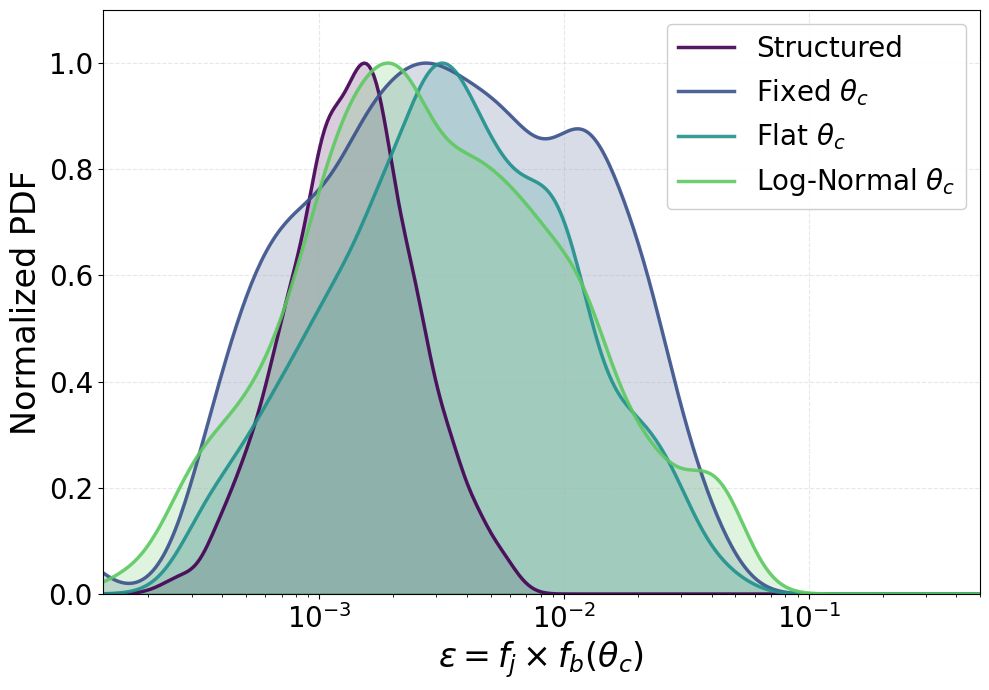

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='$\\epsilon = f_j \\times f_b(\\theta_c)$', ylabel='Normalized PDF'>)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from pathlib import Path
from scipy.stats import gaussian_kde

def plot_epsilon_posteriors_comparison(
    fiducial_name: str = "fiducial_Hrad_A1.0",
    fontsize: int = 24,
    figsize: tuple = (10, 7),
    output_path: str = None
):
    """
    Extract f_j and theta_c posteriors from fiducial population for each model,
    compute epsilon = f_j * beaming(theta_c), and plot comparison.
    
    Parameters:
        fiducial_name: Name of the fiducial population folder
        fontsize: Font size for labels
        figsize: Figure size
        output_path: If provided, save figure to this path
    """
    from src.top_hat.geometric_eff import create_geometric_efficiency_lognormal_interpolator
    
    # Define beaming functions
    def beaming_fixed(theta_c):
        """Fixed theta_c: beaming = 1 - cos(theta_c)"""
        return 1 - np.cos(np.deg2rad(theta_c))
    
    def beaming_flat(theta_max, theta_min=1):
        """Flat distribution in theta_c"""
        sin_max = np.sin(np.deg2rad(theta_max))
        sin_min = np.sin(np.deg2rad(theta_min))
        theta_max_rad = np.deg2rad(theta_max)
        theta_min_rad = np.deg2rad(theta_min)
        return 1 - (sin_max - sin_min) / (theta_max_rad - theta_min_rad)
    
    # Lognormal beaming interpolator
    geom_eff_lognormal = create_geometric_efficiency_lognormal_interpolator(
        sigma_theta_c=0.5, minimum_theta_c=0.01
    )
    
    # Model configurations
    models = {
    "Structured": {
        "path": Path("Output_files/Testing_years/alternative_fiducial_newest_bests_good_old_fj10") / "emcee.h5",
        "theta_c_idx": None,  # Not used - fixed theta_c
        "fj_idx": 6,  # f_j is the last (7th) parameter, index 6
        "discard": 3000,  # Adjust based on your MCMC run
        "thin": 15,
        "beaming_func": lambda x: 1 - np.cos(np.deg2rad(3.4)),  # Fixed beaming
        "color": "C3",
        "fixed_theta": 3.4,  # Fixed theta_c = 3.4 degrees
    },
        "Fixed $\\theta_c$": {
            "path": Path("Output_files/ProductionPop_Theta_c_10k") / fiducial_name / "emcee.h5",
            "theta_c_idx": 4,
            "fj_idx": 5,
            "discard": 1000,
            "thin": 20,
            "beaming_func": beaming_fixed,
            "color": "C0",        },
        "Flat $\\theta_c$": {
            "path": Path("Output_files/ProductionPop_Flat_10k_new_new") / fiducial_name / "emcee.h5",
            "theta_c_idx": 4,
            "fj_idx": 5,
            "discard": 5000,
            "thin": 20,
            "beaming_func": beaming_flat,
            "color": "C1",
        },
        "Log-Normal $\\theta_c$": {
            "path": Path("Output_files/ProductionPop_LN_Flat") / fiducial_name / "emcee.h5",
            "theta_c_idx": 4,
            "fj_idx": 5,
            "discard": 3000,
            "thin": 15,
            "beaming_func": geom_eff_lognormal,
            "color": "C2",
        },
    }
    #viridis colorwheel C0, C1, C2, C3
    for k, model in models.items():
        viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(models)+1))
        model["color"] = viridis_colors[list(models.keys()).index(k)]

    fig, ax = plt.subplots(figsize=figsize)
    
    epsilon_grid = np.linspace(0, 1, 500)
    
    for model_name, config in models.items():
        h5_path = config["path"]
        
        if not h5_path.exists():
            print(f"Warning: {h5_path} not found, skipping {model_name}")
            continue
        
        # Load backend
        backend = emcee.backends.HDFBackend(str(h5_path), read_only=True)
        samples = backend.get_chain(discard=config["discard"], thin=config["thin"], flat=True)
        
        # Extract f_j and theta_c
        fj_samples = samples[:, config["fj_idx"]]
        theta_c_samples = samples[:, config["theta_c_idx"]]
        
        # Compute epsilon = f_j * beaming(theta_c)
        if "fixed_theta" in config:
            # For fixed theta_c model, use fixed value
            beaming_values = config["beaming_func"](config["fixed_theta"])
            epsilon_samples = fj_samples * beaming_values
        else:
            # For variable theta_c models
            beaming_values = np.array([config["beaming_func"](t) for t in theta_c_samples])
            epsilon_samples = fj_samples * beaming_values
        
        # Filter to physical range [0, 1]
        epsilon_samples = epsilon_samples[(epsilon_samples >= 0) & (epsilon_samples <= 1)]
        
        if len(epsilon_samples) < 10:
            print(f"Warning: Not enough valid epsilon samples for {model_name}")
            continue
        
        # Compute KDE
        try:
            log10_epsilon_samples = np.log10(epsilon_samples + 1e-10)  # Avoid log(0)
            kde = gaussian_kde(log10_epsilon_samples, bw_method=0.2)

            epsilon_grid = np.logspace(-4, 1, 500)
            pdf = kde(np.log10(epsilon_grid + 1e-10))
            pdf = pdf / pdf.max()  # Normalize to peak = 1
            
            ax.plot(epsilon_grid, pdf, label=model_name, color=config["color"], 
                    linewidth=2.5, alpha=0.9)
            ax.fill_between(epsilon_grid, pdf, alpha=0.2, color=config["color"])
            
            # Print summary statistics
            median = np.median(epsilon_samples)
            p5, p95 = np.percentile(epsilon_samples, [5, 95])
            print(f"{model_name}: ε = {median:.3f} [{p5:.3f}, {p95:.3f}]")
            
        except Exception as e:
            print(f"Warning: Could not compute KDE for {model_name}: {e}")
            continue
    
    # Formatting
    ax.set_xscale("log")
    ax.set_xlabel(r"$\epsilon = f_j \times f_b(\theta_c)$", fontsize=fontsize)
    ax.set_ylabel("Normalized PDF", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 4)
    ax.set_xlim(1.3e-4, 0.5)
    ax.set_ylim(0, 1.1)
    ax.legend(fontsize=fontsize - 4, loc="upper right", framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle="--")
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Saved to {output_path}")
    
    plt.show()
    
    return fig, ax

# Example usage:
output_path_epsilon = Path("Output_files") / "epsilon_posteriors_comparison.pdf"
plot_epsilon_posteriors_comparison(fiducial_name="fiducial_Hrad_A1.0", fontsize=24, output_path=output_path_epsilon)

Saved to Output_files/fj_posteriors_comparison.pdf


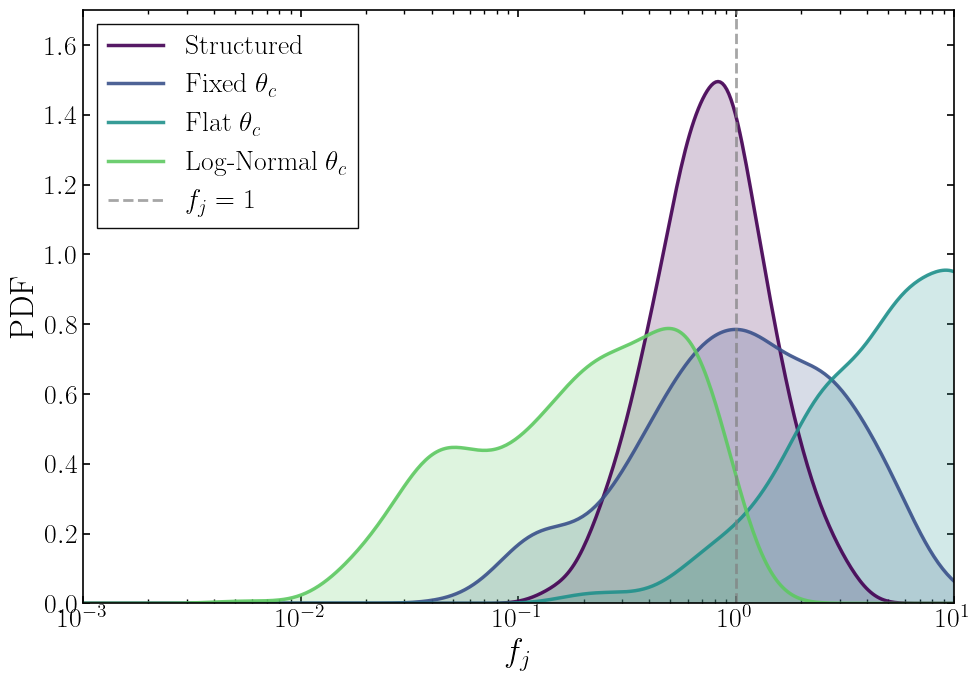

(<Figure size 1000x700 with 1 Axes>, <Axes: xlabel='$f_j$', ylabel='PDF'>)

In [ ]:
def plot_fj_posteriors_comparison(
    fiducial_name: str = "fiducial_Hrad_A1.0",
    fontsize: int = 24,
    figsize: tuple = (10, 7),
    output_path: str = None
):
    """
    Extract f_j posteriors from fiducial population for each model and plot comparison.
    """
    from src.top_hat.geometric_eff import create_geometric_efficiency_lognormal_interpolator
    
    # Lognormal beaming interpolator (needed for model config consistency)
    geom_eff_lognormal = create_geometric_efficiency_lognormal_interpolator(
        sigma_theta_c=0.5, minimum_theta_c=0.01
    )
    
    # Model configurations
    models = {
        "Structured": {
            "path": Path("Output_files/Testing_years/alternative_fiducial_newest_bests_good_old_fj10") / "emcee.h5",
            "fj_idx": 6,
            "discard": 3000,
            "thin": 15,
        },
        "Fixed $\\theta_c$": {
            "path": Path("Output_files/ProductionPop_Theta_c_10k") / fiducial_name / "emcee.h5",
            "fj_idx": 5,
            "discard": 1000,
            "thin": 20,
        },
        "Flat $\\theta_c$": {
            "path": Path("Output_files/ProductionPop_Flat_10k_new_new") / fiducial_name / "emcee.h5",
            "fj_idx": 5,
            "discard": 5000,
            "thin": 20,
        },
        "Log-Normal $\\theta_c$": {
            "path": Path("Output_files/ProductionPop_LN_Flat") / fiducial_name / "emcee.h5",
            "fj_idx": 5,
            "discard": 3000,
            "thin": 15,
        },
    }
    
    # Assign viridis colors
    viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(models) + 1))
    for i, (k, model) in enumerate(models.items()):
        model["color"] = viridis_colors[i]

    fig, ax = plt.subplots(figsize=figsize)
    
    for model_name, config in models.items():
        h5_path = config["path"]
        
        if not h5_path.exists():
            print(f"Warning: {h5_path} not found, skipping {model_name}")
            continue
        
        # Load backend
        backend = emcee.backends.HDFBackend(str(h5_path), read_only=True)
        samples = backend.get_chain(discard=config["discard"], thin=config["thin"], flat=True)
        
        # Extract f_j
        fj_samples = samples[:, -1]
        
        # Filter to positive values
        fj_samples = fj_samples[fj_samples > 0]
        
        if len(fj_samples) < 10:
            print(f"Warning: Not enough valid f_j samples for {model_name}")
            continue
        
        # Compute KDE in log space
        try:
            log10_fj_samples = np.log10(fj_samples + 1e-12)
            kde = gaussian_kde(log10_fj_samples, bw_method=0.3)

            fj_grid = np.logspace(-4, 1, 500)
            pdf = kde(np.log10(fj_grid + 1e-12))
            pdf = pdf #/ pdf.max()  # Normalize to peak = 1
            
            ax.plot(fj_grid, pdf, label=model_name, color=config["color"], 
                    linewidth=2.5, alpha=0.9)
            ax.fill_between(fj_grid, pdf, alpha=0.2, color=config["color"])
            
        except Exception as e:
            print(f"Warning: Could not compute KDE for {model_name}: {e}")
            continue
    
    # Add f_j = 1 reference line
    ax.axvline(x=1, color='gray', linestyle='--', linewidth=2, alpha=0.7, label=r'$f_j = 1$')
    
    # Formatting
    ax.set_xscale("log")
    ax.set_xlabel(r"$f_j$", fontsize=fontsize)
    ax.set_ylabel("PDF", fontsize=fontsize) 
    # inside ticks
    ax.tick_params(labelsize=fontsize - 4, direction='in')
    #inside both minor and major ticks
    ax.tick_params(which='both', direction='in')
    ax.set_xlim(1e-3, 10)
    ax.set_ylim(0, 1.7)
    ax.legend(fontsize=fontsize - 4, loc="upper left", framealpha=0.95)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight")
        print(f"Saved to {output_path}")
    
    plt.show()
    
    return fig, ax

# Example usage:
output_path_fj = Path("Output_files") / "fj_posteriors_comparison.pdf"
plot_fj_posteriors_comparison(fiducial_name="fiducial_Hrad_A1.0", fontsize=24, output_path=output_path_fj)

In [ ]:
import numpy as np
import emcee
from pathlib import Path
import matplotlib.pyplot as plt

def process_physical_fj_data(fiducial_populations: list = None):
    """
    Process MCMC chains to determine which (population, jet structure) 
    combinations have physical f_j (median < 1).
    
    Returns:
        results: dict mapping population -> structure -> bool (True = physical)
        sorted_pops: list of population names sorted by alpha and model
        struct_names: list of structure names
        counts: dict with statistics per structure
    """
    from src.pop_plot import load_json_dict
    
    # Load population names if not provided
    if fiducial_populations is None:
        population_folder = Path("datafiles") / "populations" / "samples"
        samples = list(population_folder.glob('samples_*.dat'))
        fiducial_populations = [s.name.split('samples_')[1].split('_BNSs')[0] for s in samples]
    
    # Load model dictionary for nice labels
    model_dic = load_json_dict(Path("datafiles") / "model_dic.json")
    
    # Jet structure configurations
    structures = {
        "Structured Jet": {
            "path_template": Path("Output_files/ProductionPop_fj10_20k_init_same") / "{pop}" / "emcee.h5",
            "fj_idx": 6,
            "discard": 3000,
            "thin": 15,
        },
        "Top-Hat": {
            "path_template": Path("Output_files/ProductionPop_Theta_c_10k") / "{pop}" / "emcee.h5",
            "fj_idx": 5,
            "discard": 1000,
            "thin": 20,
        },
        r"Flat $\theta_c$": {
            "path_template": Path("Output_files/ProductionPop_Flat_10k_new_new") / "{pop}" / "emcee.h5",
            "fj_idx": 5,
            "discard": 5000,
            "thin": 20,
        },
        r"Log-Normal $\theta_c$": {
            "path_template": Path("Output_files/ProductionPop_LN_Flat") / "{pop}" / "emcee.h5",
            "fj_idx": 5,
            "discard": 3000,
            "thin": 15,
        },
    }
    
    struct_names = list(structures.keys())
    
    # Results storage
    results = {pop: {} for pop in fiducial_populations}
    
    print("Processing populations...")
    for i, pop in enumerate(fiducial_populations):
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(fiducial_populations)} populations")
        
        for struct_name, config in structures.items():
            h5_path = Path(str(config["path_template"]).format(pop=pop))
            
            if not h5_path.exists():
                results[pop][struct_name] = None  # Missing
                continue
            
            try:
                backend = emcee.backends.HDFBackend(str(h5_path), read_only=True)
                samples = backend.get_chain(
                    discard=config["discard"], 
                    thin=config["thin"], 
                    flat=True
                )
                
                fj_samples = samples[:, config["fj_idx"]]
                median_fj = np.median(fj_samples)
                
                results[pop][struct_name] = median_fj < 1.0
                
            except Exception as e:
                print(f"  Error processing {pop} / {struct_name}: {e}")
                results[pop][struct_name] = None
    
    print(f"  Done! Processed {len(fiducial_populations)} populations.")
    
    # Sort populations by alpha and model name
    def sort_key(pop):
        alpha = pop[-4:]  # e.g., "A1.0"
        model = pop[:-5]  # everything before "_A1.0"
        return (alpha, model)
    
    sorted_pops = sorted(fiducial_populations, key=sort_key)
    
    # Count statistics
    counts = {s: {"physical": 0, "unphysical": 0, "missing": 0} for s in struct_names}
    
    for pop in sorted_pops:
        for struct_name in struct_names:
            val = results[pop].get(struct_name)
            if val is None:
                counts[struct_name]["missing"] += 1
            elif val:
                counts[struct_name]["physical"] += 1
            else:
                counts[struct_name]["unphysical"] += 1
    
    return results, sorted_pops, struct_names, counts, model_dic


def print_physical_fj_table(results, sorted_pops, struct_names, counts, model_dic):
    """
    Print the physical f_j table to console.
    """
    # Print table header
    # Use plain text for console output
    struct_names_plain = [s.replace(r"$\theta_c$", "θ_c") for s in struct_names]
    
    header = f"{'Population':<45} | " + " | ".join(f"{s:^15}" for s in struct_names_plain)
    separator = "-" * len(header)
    
    print("\n" + "=" * len(header))
    print("PHYSICAL f_j TABLE (✓ = median f_j < 1, ✗ = median f_j ≥ 1)")
    print("=" * len(header))
    print(header)
    print(separator)
    
    for pop in sorted_pops:
        # Get nice label
        alpha = pop[-4:]
        model = pop[:-5]
        nice_label = f"{model_dic.get(model, model)} ({alpha})"
        
        row = f"{nice_label:<45} | "
        
        for struct_name in struct_names:
            val = results[pop].get(struct_name)
            if val is None:
                symbol = "—"
            elif val:
                symbol = "✓"
            else:
                symbol = "✗"
            
            row += f"{symbol:^15} | "
        
        print(row)
    
    print(separator)
    
    # Print summary
    print("\nSUMMARY:")
    print(f"{'Structure':<20} | {'Physical (✓)':<15} | {'Unphysical (✗)':<15} | {'Missing':<10}")
    print("-" * 70)
    for struct_name, struct_plain in zip(struct_names, struct_names_plain):
        c = counts[struct_name]
        total = c["physical"] + c["unphysical"]
        pct = c["physical"] / total * 100 if total > 0 else 0
        print(f"{struct_plain:<20} | {c['physical']:^15} | {c['unphysical']:^15} | {c['missing']:^10} ({pct:.1f}% physical)")


def plot_physical_fj_table(
    results, 
    sorted_pops, 
    struct_names, 
    model_dic,
    fontsize: int = 12,
    output_path: str = None
):
    """
    Create a visual heatmap table showing physical f_j by population and jet structure.
    
    Parameters:
        results: dict from process_physical_fj_data
        sorted_pops: sorted population list
        struct_names: list of structure names
        model_dic: dictionary for nice population labels
        fontsize: font size for labels
        output_path: if provided, save figure to this path
    
    Returns:
        fig, ax: matplotlib figure and axes
    """
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patches import Patch
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(sorted_pops) * 0.25)))
    
    # Create row labels
    row_labels = []
    for pop in sorted_pops:
        alpha = pop[-4:]
        model = pop[:-5]
        row_labels.append(f"{model_dic.get(model, model)} ({alpha})")
    
    # Create data matrix
    data = []
    for pop in sorted_pops:
        row = []
        for struct_name in struct_names:
            val = results[pop].get(struct_name)
            if val is None:
                row.append(0.5)  # Gray for missing
            elif val:
                row.append(1.0)  # Green for physical
            else:
                row.append(0.0)  # Red for unphysical
        data.append(row)
    
    data = np.array(data)
    
    # Create custom colormap: red -> gray -> green
    colors = ['#d73027', '#999999', '#1a9850']  # red, gray, green
    cmap = LinearSegmentedColormap.from_list('physical', colors, N=3)
    
    # Plot heatmap
    im = ax.imshow(data, cmap=cmap, aspect='auto', vmin=0, vmax=1)
    
    # Labels
    ax.set_xticks(np.arange(len(struct_names)))
    ax.set_xticklabels(struct_names, fontsize=fontsize, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=fontsize - 2)
    
    # Add text annotations
    for i in range(len(sorted_pops)):
        for j in range(len(struct_names)):
            val = results[sorted_pops[i]].get(struct_names[j])
            if val is None:
                text = r"$-$"
            elif val:
                text = r"$\checkmark$"
            else:
                text = r"$\times$"
            ax.text(j, i, text, ha='center', va='center', fontsize=fontsize - 2,
                   color='white' if data[i, j] != 0.5 else 'black', fontweight='bold')
    
    ax.set_title(r"Physical $f_j$ by Population and Jet Structure", fontsize=fontsize + 2, pad=20)
    
    # Legend with LaTeX-compatible labels
    legend_elements = [
        Patch(facecolor='#1a9850', label=r'Physical ($f_j < 1$)'),
        Patch(facecolor='#d73027', label=r'Unphysical ($f_j \geq 1$)'),
        Patch(facecolor='#999999', label='Missing data'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=fontsize - 2)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nSaved figure to {output_path}")
    
    plt.show()
    
    return fig, ax


# ==========================================
# Run the processing and plotting separately
# ==========================================

# Step 1: Process data (slow - reads all MCMC chains)
results, sorted_pops, struct_names, counts, model_dic = process_physical_fj_data()

Processing populations...
  Processed 10/64 populations
  Processed 20/64 populations
  Processed 30/64 populations
  Processed 40/64 populations
  Processed 50/64 populations
  Processed 60/64 populations
  Done! Processed 64 populations.



PHYSICAL f_j TABLE (✓ = median f_j < 1, ✗ = median f_j ≥ 1)
Population                                    | Structured Jet  |     Top-Hat     |    Flat θ_c     | Log-Normal θ_c 
---------------------------------------------------------------------------------------------------------------------
OPT (A0.5)                                    |        ✗        |        ✗        |        ✗        |        ✓        | 
F (A0.5)                                      |        ✗        |        ✗        |        ✗        |        ✓        | 
F5M (A0.5)                                    |        ✗        |        ✗        |        ✗        |        ✓        | 
SND (A0.5)                                    |        ✗        |        ✗        |        ✗        |        ✓        | 
RBSE (A0.5)                                   |        ✗        |        ✗        |        ✗        |        ✓        | 
K150 (A0.5)                                   |        ✗        |        ✗        |        ✗      

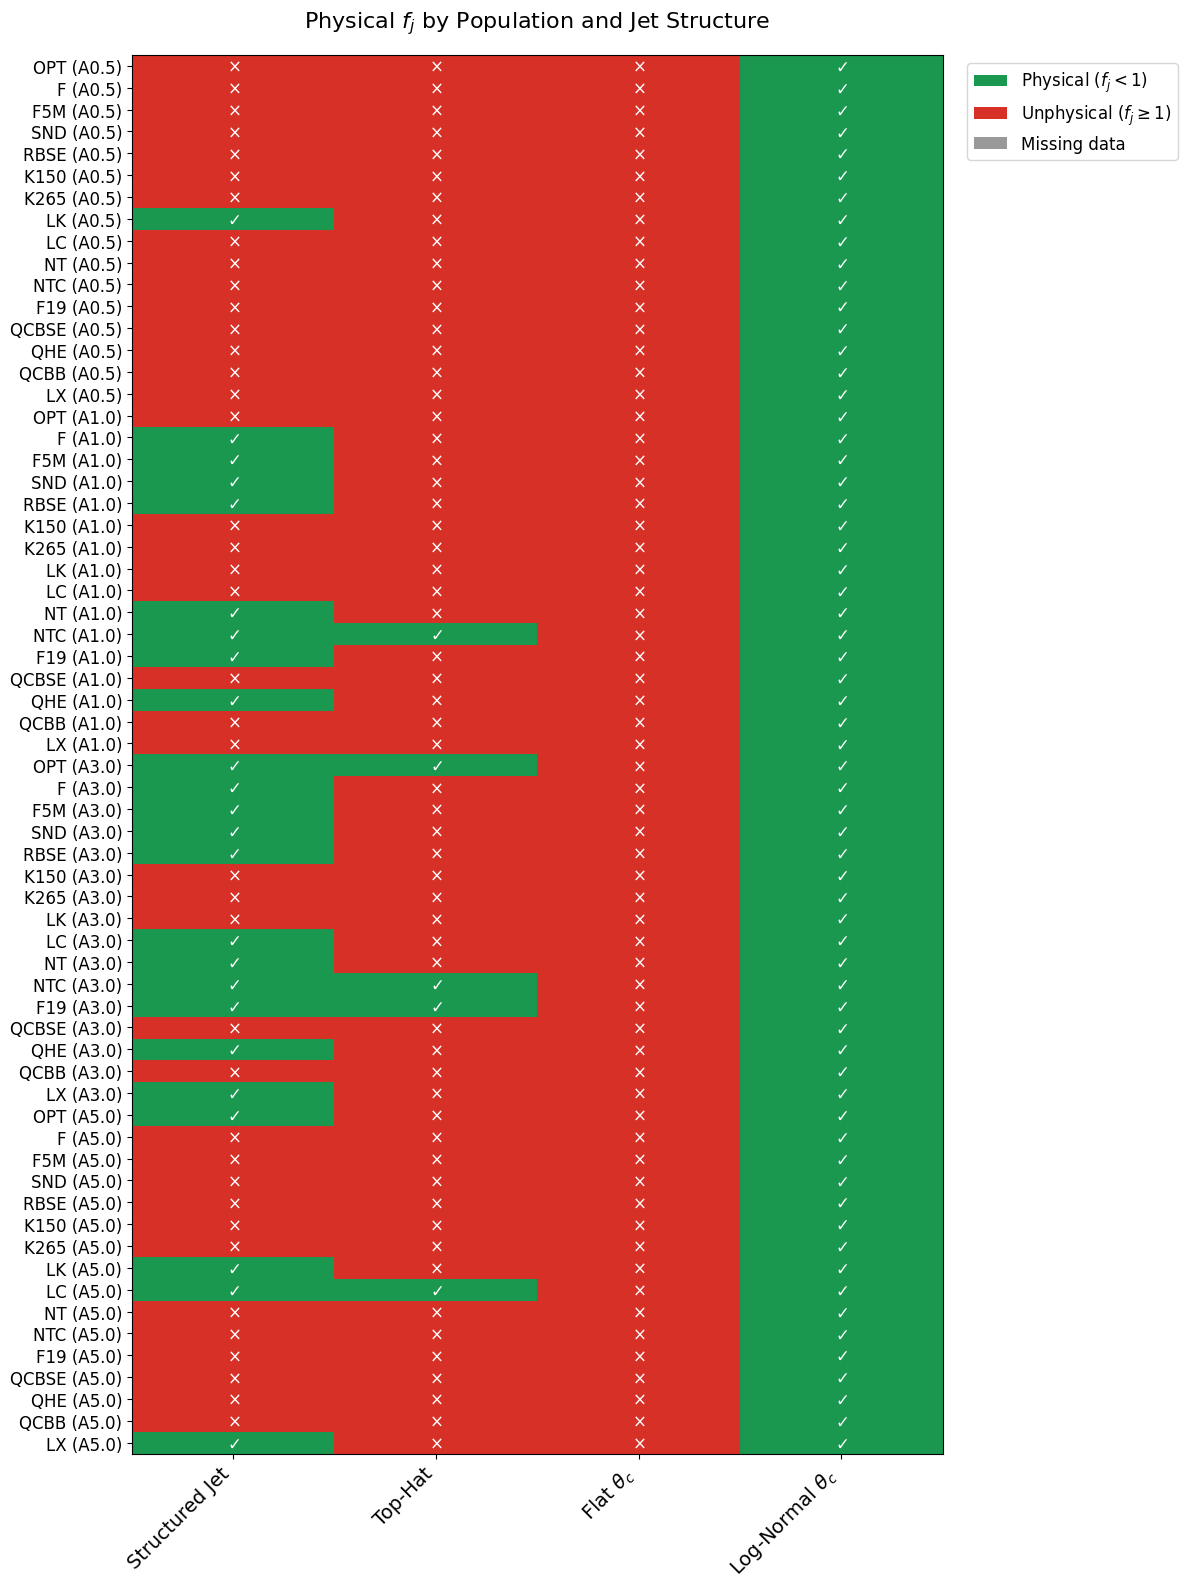

In [ ]:
# Step 2: Print text table
print_physical_fj_table(results, sorted_pops, struct_names, counts, model_dic)

# Step 3: Plot visual table
fig, ax = plot_physical_fj_table(
    results, sorted_pops, struct_names, model_dic,
    fontsize=14,
    output_path="Output_files/physical_fj_table.pdf"
)

In [ ]:
import numpy as np
import emcee
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# --- Constants & Helpers ---
ROUCO_MEDIAN_THETA_C    = 6.1  # degrees
ROUCO_UPPER_90_BOUND    = 10.0 # degrees, placeholder for Flat theta asterisk check
LOGNORMAL_SIGMA         = 0.5       # Assumed sigma for LogNormal reference

def beaming_fixed(theta_deg):
    """Beaming factor for fixed opening angle."""
    return 1 - np.cos(np.deg2rad(theta_deg))

def beaming_flat_distribution(theta_max, theta_min=1.0):
    """
    Average beaming factor for a flat distribution of theta_c in [theta_min, theta_max].
    Equation: <fb> = [ (theta - sin(theta)) ]_min^max / (max - min) (theta in radians)
    """
    t_min_rad = np.deg2rad(theta_min)
    t_max_rad = np.deg2rad(theta_max)
    
    term_max = t_max_rad - np.sin(t_max_rad)
    term_min = t_min_rad - np.sin(t_min_rad)
    
    # Avoid division by zero
    if abs(t_max_rad - t_min_rad) < 1e-6:
        return 1 - np.cos(t_max_rad)
        
    return (term_max - term_min) / (t_max_rad - t_min_rad)

def fraction_above_threshold_lognormal(median, sigma, threshold=15.0):
    """Calculate fraction of LogNormal distribution above threshold angle."""
    # Convert parameters to log-space mu and s(sigma)
    shape = sigma * np.log(10)
    scale = median
    # Survival function (1 - CDF) at threshold
    return lognorm.sf(threshold, s=shape, scale=scale)

# --- Main Processing Function ---

def process_physical_fj_data(fiducial_populations: list = None):
    """
    Process MCMC chains with Rouco-based normalization logic.
    """
    from src.pop_plot import load_json_dict
    from src.top_hat.geometric_eff import create_geometric_efficiency_lognormal_interpolator

    # Prepare LogNormal Beaming Interpolator for Reference (Rouco Median = 6.1)
    # We calculate the beaming factor for the specific Rouco case
    avg_beaming_ln_rouco = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)(ROUCO_MEDIAN_THETA_C)
    
    # Calculate Ref Beaming for Flat (Median 6.1 => Max 11.2)
    flat_theta_max_ref = 2 * ROUCO_MEDIAN_THETA_C - 1.0 # (1 + max)/2 = 6.1 => max = 11.2
    avg_beaming_flat_rouco = beaming_flat_distribution(flat_theta_max_ref)
    
    # Ref Beaming for Top-Hat (Fixed 6.1)
    beaming_tophat_rouco = beaming_fixed(ROUCO_MEDIAN_THETA_C)
    
    # Load population names
    if fiducial_populations is None:
        population_folder = Path("datafiles") / "populations" / "samples"
        samples = list(population_folder.glob('samples_*.dat'))
        fiducial_populations = [s.name.split('samples_')[1].split('_BNSs')[0] for s in samples]
    
    model_dic = load_json_dict(Path("datafiles") / "model_dic.json")
    
    structures = {
        "Structured Jet": {
            "path_template": Path("Output_files/ProductionPop_fj10_20k_init_same") / "{pop}" / "emcee.h5",
            "fj_idx": 6, "theta_idx": None,
            "discard": 3000, "thin": 15,
            "type": "structured"
        },
        "Top-Hat": {
            "path_template": Path("Output_files/ProductionPop_Theta_c_10k") / "{pop}" / "emcee.h5",
            "fj_idx": 5, "theta_idx": 4, # Theta is sampled here
            "discard": 1000, "thin": 20,
            "type": "tophat"
        },
        r"Flat $\theta_c$": {
            "path_template": Path("Output_files/ProductionPop_Flat_10k_new_new") / "{pop}" / "emcee.h5",
            "fj_idx": 5, "theta_idx": 4, # Theta_max
            "discard": 5000, "thin": 20,
            "type": "flat"
        },
        r"Log-Normal $\theta_c$": {
            "path_template": Path("Output_files/ProductionPop_LN_Flat") / "{pop}" / "emcee.h5",
            "fj_idx": 5, "theta_idx": 4, # Theta_median
            "discard": 3000, "thin": 15,
            "type": "lognormal"
        },
    }
    
    struct_names = list(structures.keys())
    results = {pop: {} for pop in fiducial_populations}
    
    print("Processing populations...")
    for i, pop in enumerate(fiducial_populations):
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(fiducial_populations)}")
        
        for struct_name, config in structures.items():
            h5_path = Path(str(config["path_template"]).format(pop=pop))
            
            res = {"physical": None, "asterisk": False, "missing": True}
            
            if h5_path.exists():
                try:
                    backend = emcee.backends.HDFBackend(str(h5_path), read_only=True)
                    chain = backend.get_chain(discard=config["discard"], thin=config["thin"], flat=True)
                    
                    fj_samples = chain[:, config["fj_idx"]]
                    
                    if config["type"] == "structured":
                        # Direct check
                        res["physical"] = np.median(fj_samples) < 1.0
                        res["missing"] = False
                    
                    elif config["type"] == "tophat":
                        # Re-normalize to Rouco Top-Hat
                        theta_samples = chain[:, config["theta_idx"]]
                        # Epsilon = fj_sample * beaming(theta_sample)
                        eps_samples = fj_samples * (1 - np.cos(np.deg2rad(theta_samples)))
                        # Implied fj = Epsilon / beaming(Rouco)
                        fj_implied = eps_samples / beaming_tophat_rouco
                        
                        res["physical"] = np.median(fj_implied) < 1.0
                        res["missing"] = False
                        
                    elif config["type"] == "flat":
                        # Re-normalize to Rouco Flat
                        theta_max_samples = chain[:, config["theta_idx"]]
                        # Epsilon calculation needs correct beaming for each sample's theta_max
                        # Vectorize calculation approx or loop
                        beaming_sample = np.array([beaming_flat_distribution(t) for t in theta_max_samples])
                        eps_samples = fj_samples * beaming_sample
                        
                        fj_implied = eps_samples / avg_beaming_flat_rouco
                        res["physical"] = np.median(fj_implied) < 1.0
                        
                        # Asterisk: Theta* (median theta_max) > Rouco Upper Bound
                        median_theta_max = np.median(theta_max_samples)
                        if median_theta_max > ROUCO_UPPER_90_BOUND:
                            res["asterisk"] = True
                        res["missing"] = False
                        
                    elif config["type"] == "lognormal":
                        theta_med_samples = chain[:, config["theta_idx"]]
                        gen_interp = create_geometric_efficiency_lognormal_interpolator(
                            sigma_theta_c=LOGNORMAL_SIGMA, n_points=100
                        ) 
                        
                        beaming_sample = gen_interp(theta_med_samples)
                        eps_samples = fj_samples * beaming_sample
                        
                        fj_implied = eps_samples / avg_beaming_ln_rouco
                        res["physical"] = np.median(fj_implied) < 1.0
                        
                        # Asterisk: Median model has >10% angles > 15 deg
                        median_theta_med = np.median(theta_med_samples)
                        frac_above_15 = fraction_above_threshold_lognormal(median_theta_med, LOGNORMAL_SIGMA, threshold=15.0)
                        if frac_above_15 > 0.10:
                            res["asterisk"] = True
                        res["missing"] = False

                except Exception as e:
                    print(f"Error {pop} {struct_name}: {e}")
            
            results[pop][struct_name] = res

    # Sort populations
    def sort_key(pop):
        return (pop[-4:], pop[:-5])
    
    sorted_pops = sorted(fiducial_populations, key=sort_key)
    
    # Counts
    counts = {s: {"physical": 0, "unphysical": 0, "missing": 0, "asterisk": 0} for s in struct_names}
    for pop in sorted_pops:
        for s in struct_names:
            r = results[pop][s]
            if r["missing"]:
                counts[s]["missing"] += 1
            elif r["physical"]:
                counts[s]["physical"] += 1
            else:
                counts[s]["unphysical"] += 1
            
            if r.get("asterisk"):
                counts[s]["asterisk"] += 1
                
    return results, sorted_pops, struct_names, counts, model_dic

def plot_physical_fj_table_rouco(
    results, 
    sorted_pops, 
    struct_names, 
    model_dic,
    fontsize: int = 12,
    output_path: str = None
):
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patches import Patch
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(sorted_pops) * 0.3)))
    
    # Data Matrix for colors
    data = []
    row_labels = []
    
    for pop in sorted_pops:
        alpha = pop[-4:]
        model = pop[:-5]
        row_labels.append(f"{model_dic.get(model, model)} ({alpha})")
        
        row = []
        for s in struct_names:
            res = results[pop][s]
            if res["missing"]:
                row.append(0.5) # Gray
            elif res["physical"]:
                row.append(1.0) # Green
            else:
                row.append(0.0) # Red
        data.append(row)
    
    data = np.array(data)
    
    colors = ['#d73027', '#999999', '#1a9850'] # Red, Gray, Green
    cmap = LinearSegmentedColormap.from_list('physical', colors, N=3)
    
    im = ax.imshow(data, cmap=cmap, aspect='auto', vmin=0, vmax=1)
    
    # Grid
    ax.set_xticks(np.arange(len(struct_names)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticks(np.arange(len(struct_names)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(row_labels)+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.set_xticklabels(struct_names, fontsize=fontsize, rotation=45, ha='right')
    ax.set_yticklabels(row_labels, fontsize=fontsize - 2)
    
    # Annotations
    for i in range(len(sorted_pops)):
        for j in range(len(struct_names)):
            res = results[sorted_pops[i]][struct_names[j]]
            
            if res["missing"]:
                text = r"$-$"
            else:
                base = r"$\checkmark$" if res["physical"] else r"$\times$"
                if res["asterisk"]:
                    base += r"$^{*}$"
                text = base
            
            ax.text(j, i, text, ha='center', va='center', fontsize=fontsize,
                   color='white' if data[i, j] != 0.5 else 'black', fontweight='bold')

    ax.set_title(r"Physical $f_j$ (Fixed Rouco Median $\theta_c$)", fontsize=fontsize+2, pad=20)
    
    legend_elements = [
        Patch(facecolor='#1a9850', label=r'Physical ($f_j < 1$)'),
        Patch(facecolor='#d73027', label=r'Unphysical ($f_j \geq 1$)'),
        Patch(facecolor='#999999', label='Missing'),
        # Invisible patch with asterisk for legend
        Patch(facecolor='white', label=r'$*$: $\theta^*$ too wide', alpha=0) 
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {output_path}")
    plt.show()
    return fig, ax

# === Execution ===
# process
results_rouco, sorted_pops_r, struct_names_r, counts_r, model_dic_r = process_physical_fj_data()


Processing populations...
  Processed 10/64
  Processed 20/64
  Processed 30/64
  Processed 40/64
  Processed 50/64
  Processed 60/64


In [ ]:


# --- 3. Process Table Data with Rouco Logic ---
from src.pop_plot import load_json_dict

def generate_rouco_physics_table(
    theta_stars_fixed,
    theta_stars_flat,
    theta_stars_ln,
    tail_fractions_ln,
    rouco_theta_limit   =   15.4, # User specified limit (6.1 + 9.3)
    ln_tail_limit       =   0.10      # User specified 10% limit
):
    # --- Constants for Rouco Normalization ---
    ROUCO_MEDIAN = 6.1
    # Beaming factor for Top-Hat at 6.1 deg
    beaming_tophat_rouco = 1 - np.cos(np.deg2rad(ROUCO_MEDIAN))
    
    # Beaming factor for Flat (Median 6.1 => Max ~11.2)
    flat_theta_max_ref = 2 * ROUCO_MEDIAN - 1.0 
    beaming_flat_rouco = beaming_efficiency(flat_theta_max_ref)
    
    # Beaming factor for LogNormal (Median 6.1, Sigma 0.5)
    beaming_ln_rouco = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)(ROUCO_MEDIAN)
    
    # Setup
    population_folder = Path("datafiles") / "populations" / "samples"
    samples = list(population_folder.glob('samples_*.dat'))
    fiducial_populations = [s.name.split('samples_')[1].split('_BNSs')[0] for s in samples]
    model_dic = load_json_dict(Path("datafiles") / "model_dic.json")
    
    structures = {
        "Fixed":    {"path": Path("Output_files/ProductionPop_Theta_c_10k"),       "fj_idx": 5, "beaming_ref": beaming_tophat_rouco},
        "Flat":     {"path": Path("Output_files/ProductionPop_Flat_10k_new_new"),  "fj_idx": 5, "beaming_ref": beaming_flat_rouco},
        "LogNormal":{"path": Path("Output_files/ProductionPop_LN_Flat"),           "fj_idx": 5, "beaming_ref": beaming_ln_rouco},
        "Structured": {"path": Path("Output_files/ProductionPop_fj10_20k_init_same"), "fj_idx": 6, "beaming_ref": None}
    }
    
    table_rows = []
    
    # Sorting
    def sort_key(pop): return (pop[-4:], pop[:-5])
    sorted_pops = sorted(fiducial_populations, key=sort_key)
    
    print(f"{'Population':<40} | {'Fixed':<10} | {'Flat':<10} | {'LogNorm':<10} | {'Structured':<10}")
    print("-" * 100)
    
    results = {}

    for pop in sorted_pops:
        row_data = {"name": model_dic.get(pop[:-5], pop[:-5]) + f" ({pop[-4:]})", "pop_key": pop}
        print_row = f"{row_data['name']:<40} | "
        
        for struct_name, config in structures.items():
            base_dir = config["path"] / pop
            h5_path = base_dir / "emcee.h5"
            cell_str = "-"
            
            if h5_path.exists():
                try:
                    # Get Median f_j
                    backend = emcee.backends.HDFBackend(str(h5_path), read_only=True)
                    # Read only last chunk to save time
                    chain = backend.get_chain(discard=1000, thin=20, flat=True)
                    fj_samples = chain[:, config["fj_idx"]]
                    
                    # 1. Beaming Correction (Rouco Check)
                    if config["beaming_ref"] is not None:
                        # We need the actual Theta samples to de-bias
                        # But as a shortcut approximation for "Rouco Normalization":
                        # We assume the model found the "correct" physical rate R_true = <fj> * <fb_model> * R_intrinsic
                        # So <fj_rouco> = (<fj_model> * <fb_model>) / <fb_rouco>
                        # But <fj_model> * <fb_model> IS the epsilon we capture in plots implicitly.
                        # However, strictly:
                        
                        theta_idx = 4 if struct_name != "Structured" else None
                        if theta_idx is not None:
                            theta_samples = chain[:, theta_idx]
                            
                            if struct_name == "Fixed":
                                model_beaming = 1 - np.cos(np.deg2rad(theta_samples))
                            elif struct_name == "Flat":
                                model_beaming = np.array([beaming_efficiency(t) for t in theta_samples])
                            elif struct_name == "LogNormal":
                                model_beaming = geom_eff_lognormal(theta_samples) # approximated array call
                                
                            epsilon_samples = fj_samples * model_beaming
                            fj_rouco_samples = epsilon_samples / config["beaming_ref"]
                            median_fj = np.median(fj_rouco_samples)
                        else:
                             median_fj = np.median(fj_samples)
                    else:
                        median_fj = np.median(fj_samples) # Structured (no theta variation usually in this context)

                    # 2. Check Physicality
                    is_physical = median_fj < 1.0
                    
                    # 3. Check Constraints (Asterisks)
                    is_wide = False
                    
                    if struct_name == "Flat":
                        # Constraint: Theta* > 15.4 deg
                        th_star = theta_stars_flat.get(pop, 0)
                        if th_star > rouco_theta_limit:
                            is_wide = True
                    
                    elif struct_name == "Fixed":
                        # Constraint: Theta* > 15.4 deg
                        th_star = theta_stars_fixed.get(pop, 0)
                        if th_star > rouco_theta_limit:
                            is_wide = True

                    elif struct_name == "LogNormal":
                        # Constraint: Tail Fraction > 10%
                        tail_frac = tail_fractions_ln.get(pop, 0)
                        th_star = theta_stars_ln.get(pop, 0)
                        if tail_frac > ln_tail_limit or th_star > rouco_theta_limit:
                            is_wide = True

                    # 4. Format Symbol
                    if is_physical:
                        symbol = "\\checkmark"
                    else:
                        symbol = "\\times"
                        
                    if is_wide:
                        symbol += "^*"
                        
                    cell_str = f"${symbol}$"
                    
                except Exception as e:
                    cell_str = "?"
            
            row_data[struct_name] = cell_str
            print_row += f"{cell_str:<10} | "
        
        table_rows.append(row_data)
        print(print_row)
        
    return table_rows

# Execute Logic
latex_data = generate_rouco_physics_table(theta_stars_fixed=theta_stars_fixed, theta_stars_flat=theta_stars_flat, theta_stars_ln=theta_stars_ln, tail_fractions_ln=tail_fractions_ln)
                                              #theta_stars_flat, tail_fractions_ln)

# --- 4. Print LaTeX Body ---
print("\n\n=== LATEX TABLE BODY ===\n")
for row in latex_data:
    line = f"{row['name']} & {row['Fixed']} & {row['Flat']} & {row['LogNormal']} & {row['Structured']} \\"
print(line)